In [2]:
import sys
sys.path.append("/home/ubuntu/fs/dsb17/code")

In [11]:
import dicom
from glob import glob
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

import matplotlib.pyplot as plt

from keras.models import Model

import lunaIterator; reload(lunaIterator)
from lunaIterator import lunaIterator

import lunaModel; reload(lunaModel)
from lunaModel import get_unet

%matplotlib inline

In [4]:
data_path = '/home/ubuntu/fs/data/dsb17/'

luna_path = data_path+'luna16/'
weights_path = luna_path+'results/'

scan_path = data_path+'stage1/'
labels_file = data_path+'stage1_labels.csv'
test_file = data_path+'stage1_sample_submission.csv'
results_path = data_path+'results/'

## Steps

Find nodules
1. Load DICOM image
2. Preprocess same as luna16
3. Predict nodule from unet segmenter
4. Save nodule mask

Feature extract
1. Load all masks for patient
2. Extract hand designed features
3. Save feature vector with cancer id

(in another nb)

Train simple classifier
1. Load feature vector for train data
2. Train classifier using cross-validation

Predict Cancer
1. Load feature vector for test data
2. Predict cancer
3. Profit

## Segment dsb17

In [88]:
model = get_unet()
model.load_weights(weights_path+'weights_1e-5_04_-0.601.hdf5')

In [16]:
df = pd.read_csv(labels_file)
df.sort_values(by='id')
df.head()

id  cancer
0  0015ceb851d7251b8f399e39779d1e7d       1
1  0030a160d58723ff36d73f41b170ec21       0
2  003f41c78e6acfa92430a057ac0b306e       0
3  006b96310a37b36cccb2ab48d10b49a3       1
4  008464bb8521d09a42985dd8add3d0d2       1

In [23]:
uid = df.loc[0, 'id']
print uid

0015ceb851d7251b8f399e39779d1e7d


In [29]:
# get all files for uid
scans = glob(scan_path+uid+'/*.dcm')
print len(scans)

195


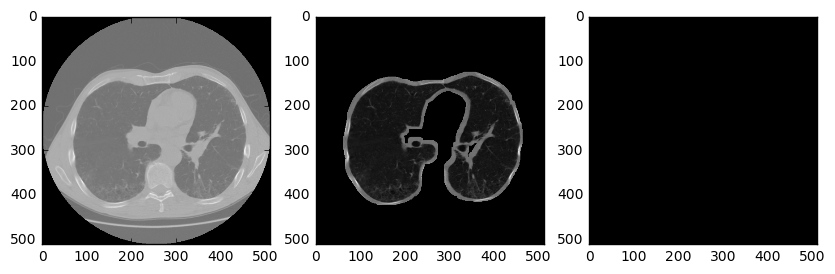

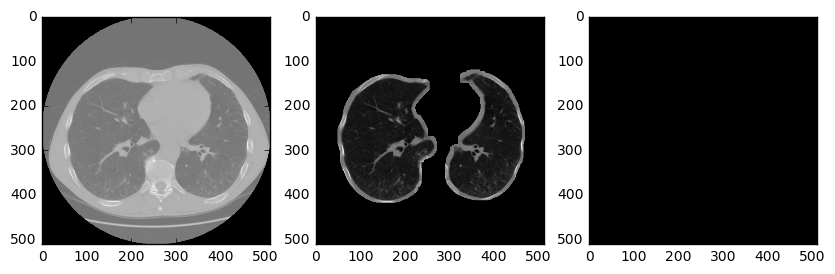

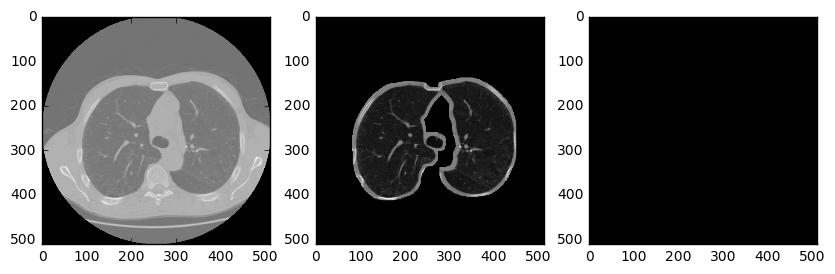

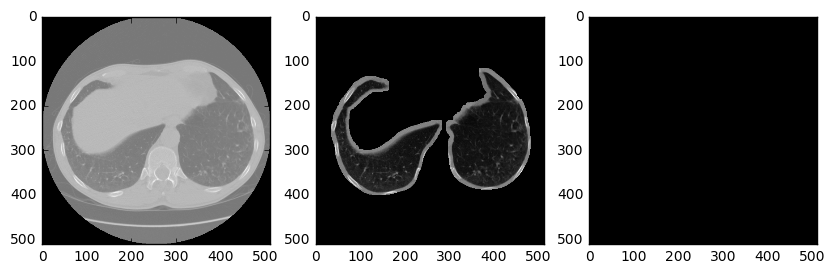

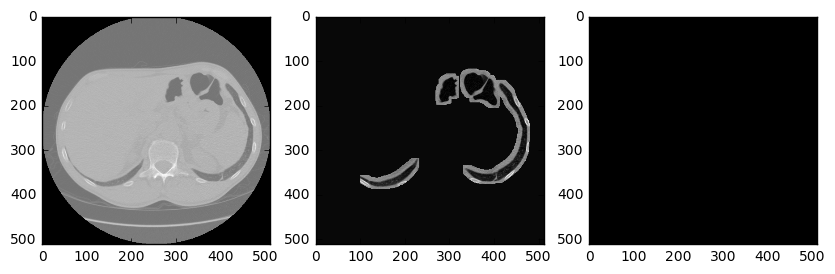

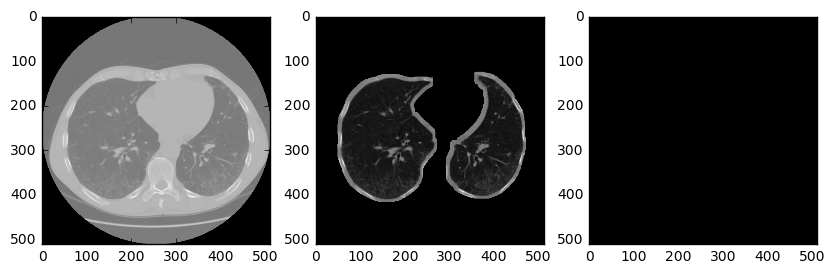

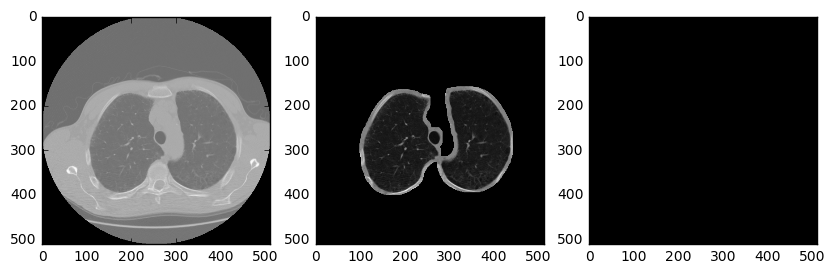

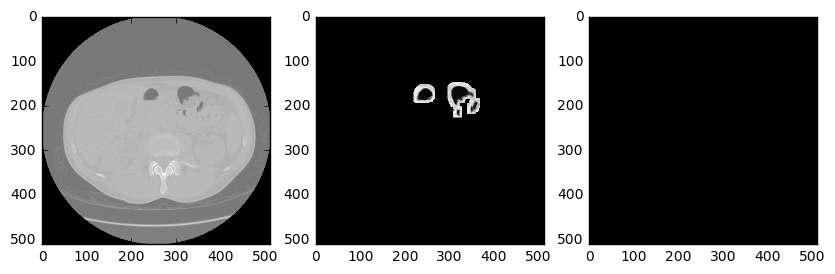

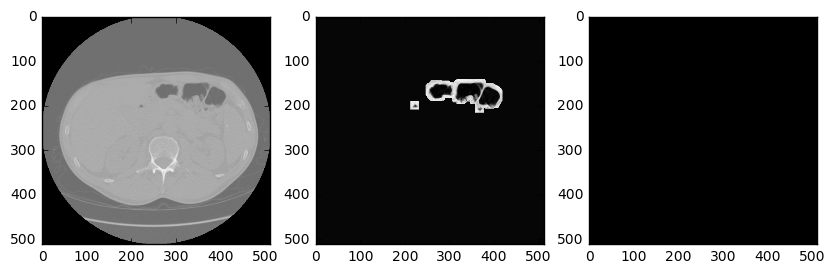

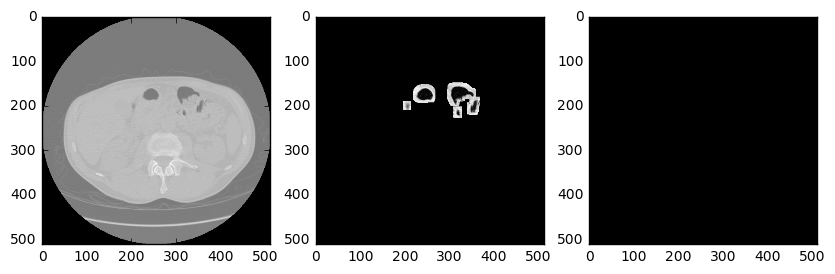

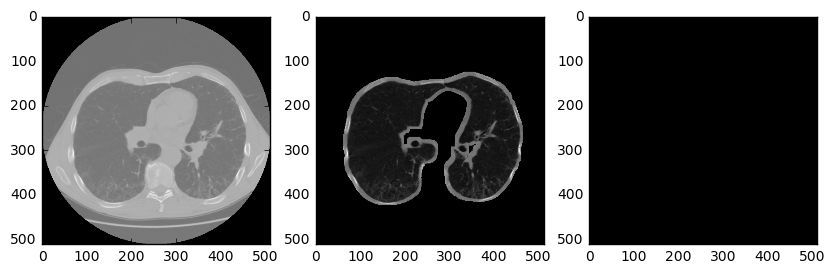

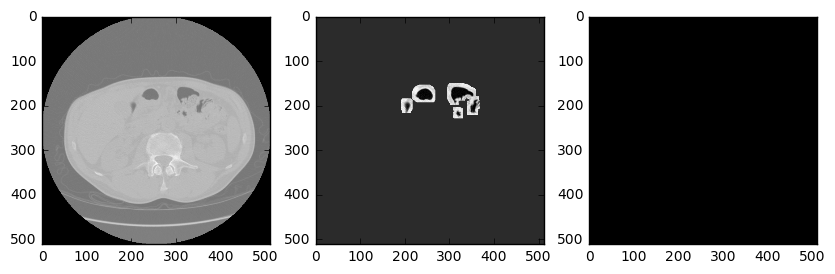

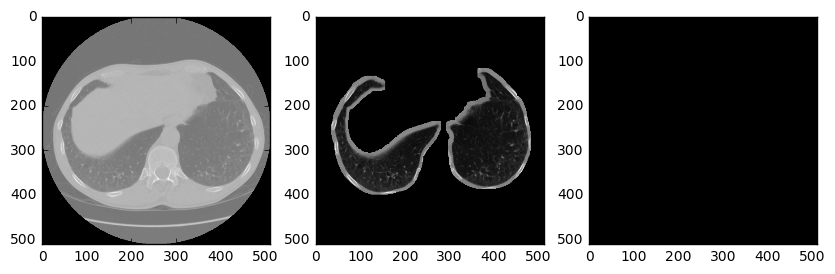

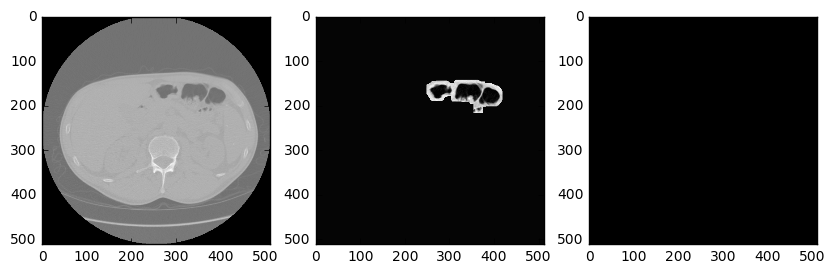

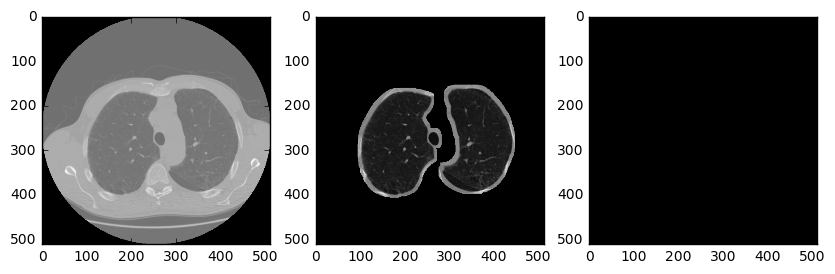

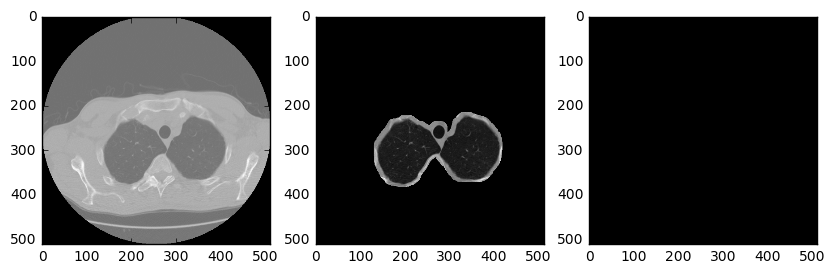

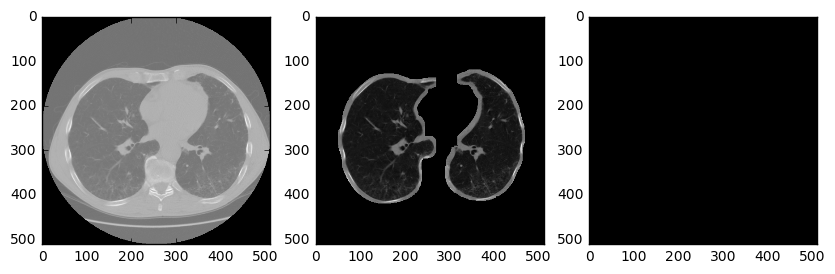

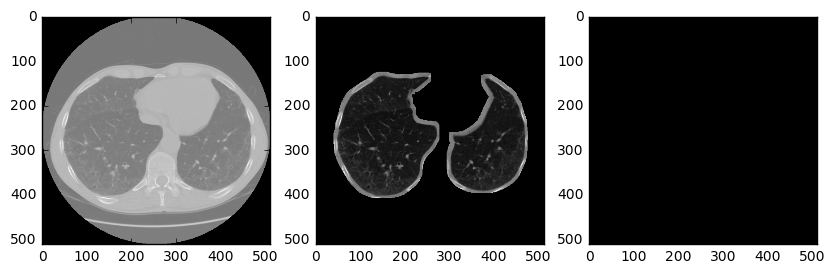

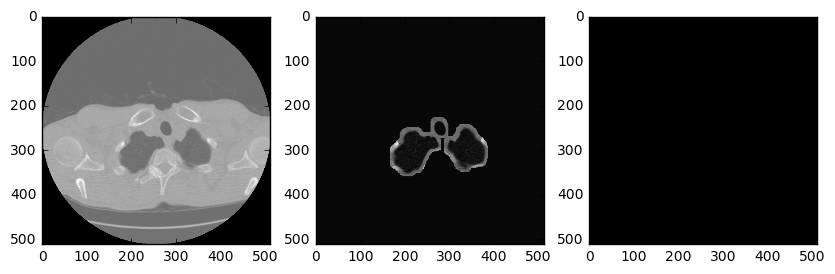

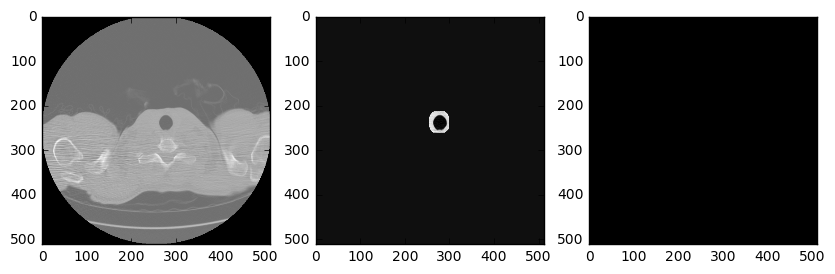

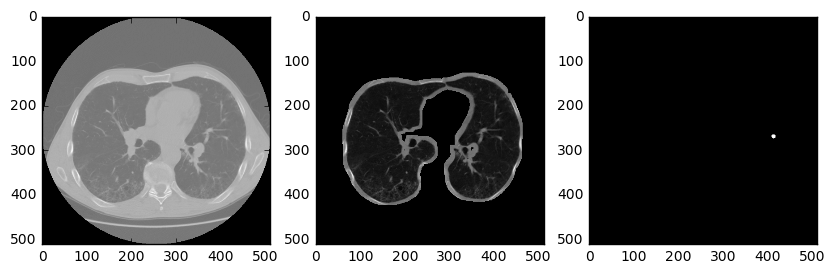

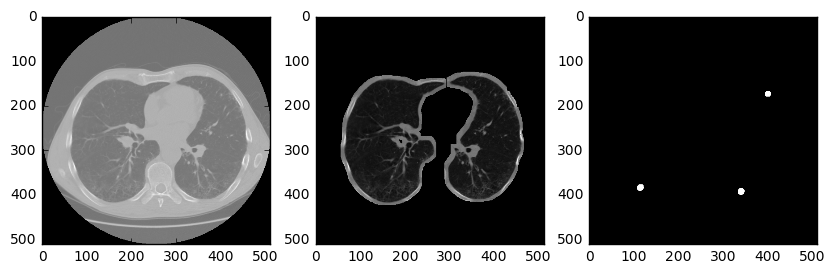

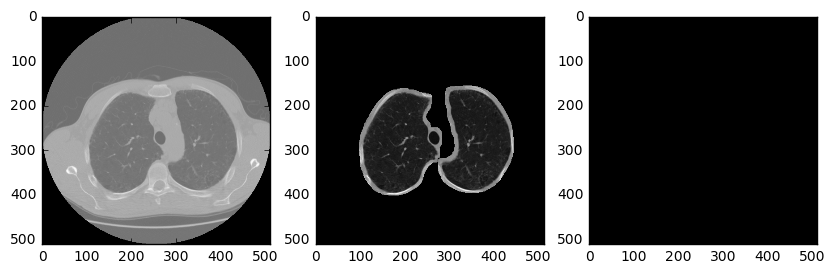

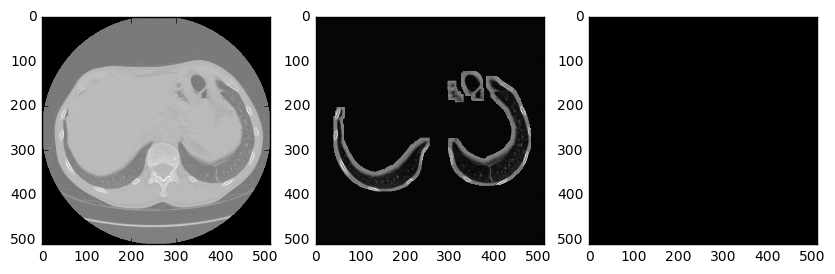

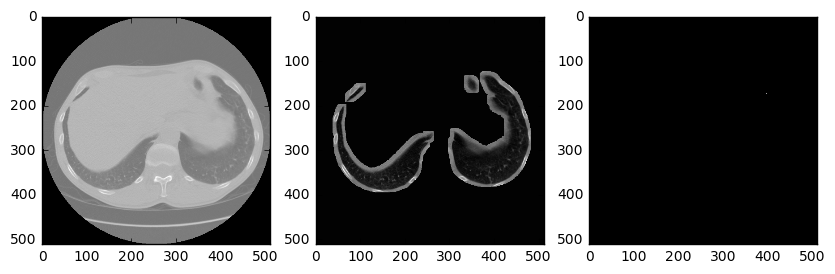

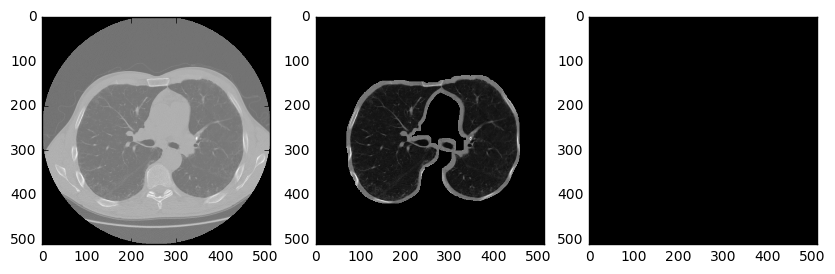

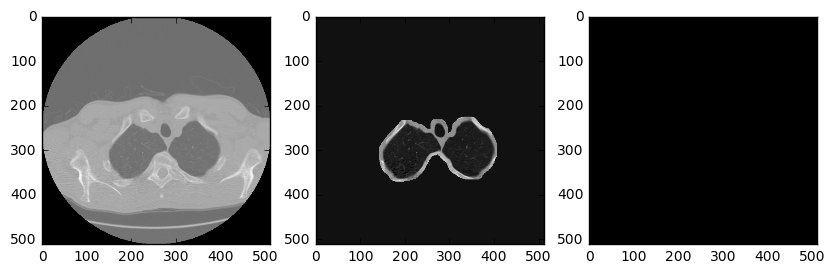

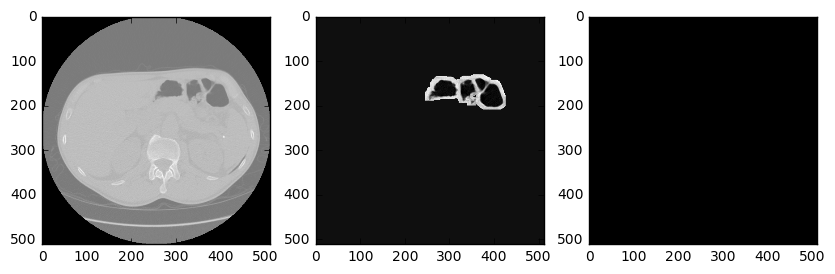

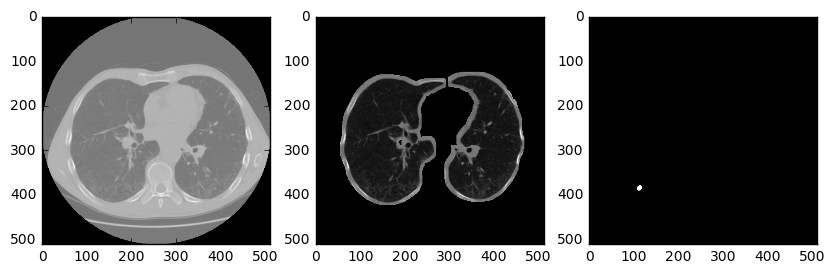

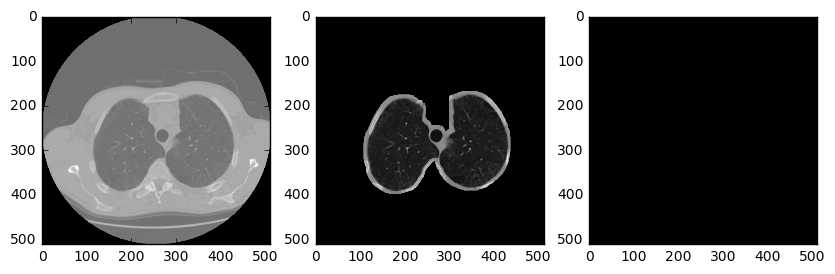

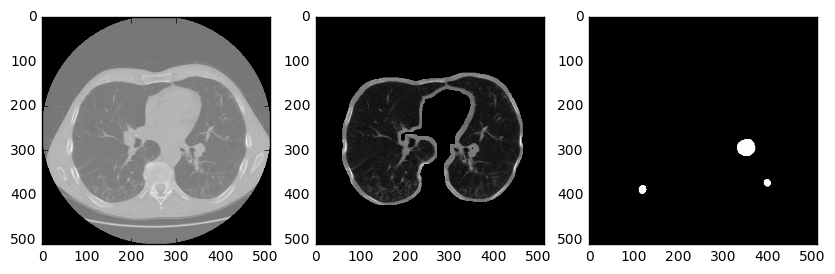

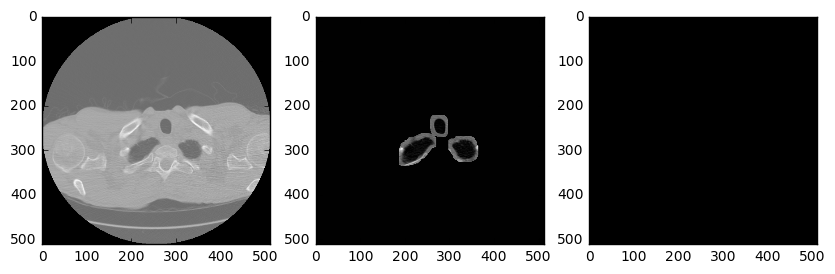

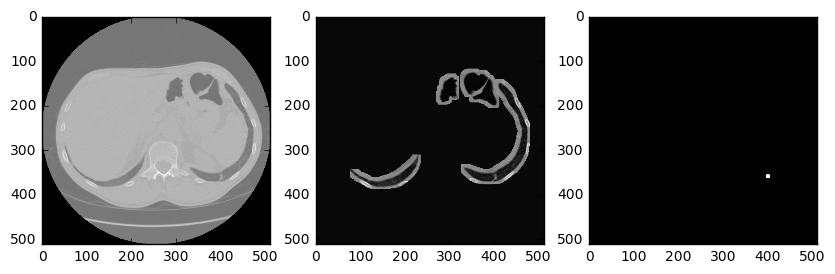

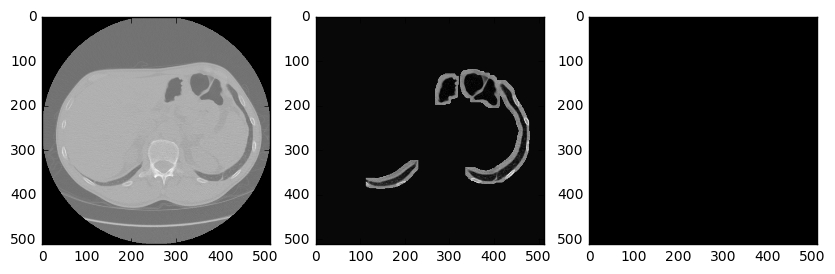

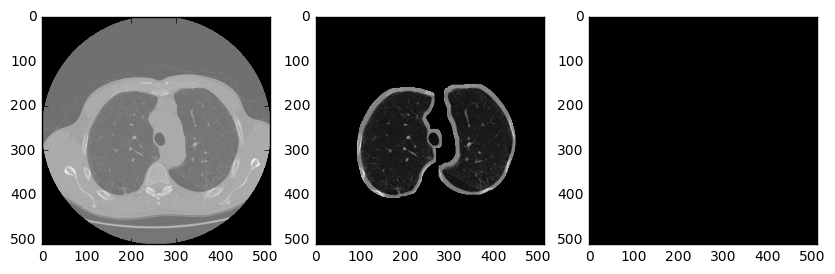

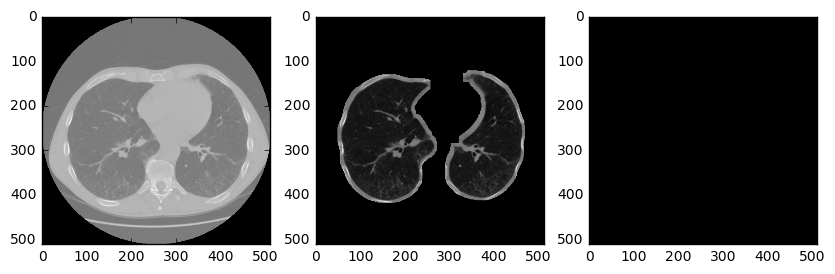

In [64]:
lungs = np.ndarray([1, 1, 512, 512])
for i in range(0,5):
    dcm = dicom.read_file(scans[i])
    img = dcm.pixel_array
    lungs[0, 0] = segment_lungs(img)
    nod = model.predict(lungs)
    
    fig, ax = plt.subplots(1,3,figsize=[10,10])
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].imshow(lungs[0,0], cmap=plt.cm.gray)
    ax[2].imshow(nod[0,0], cmap=plt.cm.gray)
    plt.show()

In [52]:
# import time
# from tqdm import tqdm
# start = time.time()

# lungs = np.ndarray([len(scans), 1, 512, 512])
# for i in tqdm(range(len(scans))):
#     dcm = dicom.read_file(scans[i])
#     img = dcm.pixel_array
    
#     lung = np.ndarray([1, 512, 512])
#     lung[0] = segment_lungs(img)
#     lungs[i] = lung
    
# end = time.time()
# print(end-start)

100%|██████████| 195/195 [01:05<00:00,  2.47it/s]

65.4896759987


In [53]:
# start = time.time()
# nod = model.predict(lungs, batch_size=2, verbose=1)
# end = time.time()
# print(end-start)

195/195 [==============================] - 54s    
54.8079049587


In [54]:
# nod.shape

(195, 1, 512, 512)

In [59]:
# np.save(data_path+'segmented/'+uid+'.npy', nod.astype('uint8'))

That was too slow

## Generator

In [75]:
img_width = 512
img_height = 512

class dsbIterator(object):
    
    def __init__(self, files, batch_size=2, shuffle=False, seed=None):
        self.files = files
        self.n = len(files)
        self.batch_size = batch_size
        self.batch_index = 0
        self.total_batches_seen = 0
        self.index_generator = self._gen_index(self.n, batch_size, shuffle, seed)
        
    def reset(self):
        self.batch_index = 0
        
    def _gen_index(self, n , batch_size=32, shuffle=False, seed=None):
        
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)
                    
            current_index = (self.batch_index * batch_size) % n
            if n >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield(index_array[current_index: current_index + current_batch_size],
                     current_index, current_batch_size)
            
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        
        index_array, current_index, current_batch_size = next(self.index_generator)

        lungs = np.ndarray([current_batch_size, 1, img_width, img_height])
        for i in range(0, current_batch_size):
            
            # get image data and file
            dcm = dicom.read_file(self.files[i])
            img = dcm.pixel_array
            
            # segment lungs
            lungs[i, 0] = segment_lungs(img)
            
        return lungs

In [87]:
start = time.time()

uid = df.loc[0, 'id']
scans = glob(scan_path+uid+'/*.dcm')
dsb_gen = dsbIterator(scans)
nod = model.predict_generator(dsb_gen, len(scans))
print(nod.shape)
np.save(data_path+'segmented/'+uid+'.npy', nod.astype('uint8'))

end = time.time()
print(end-start)

(195, 1, 512, 512)
83.241658926


In [ ]:
df = pd.read_csv(labels_file)
df.sort_values(by='id')
model = get_unet()
model.load_weights(weights_path+'weights_1e-5_04_-0.601.hdf5')

for i in tqdm(range(10)):
    uid = df.loc[i, 'id']
    scans = glob(scan_path+uid+'/*.dcm')
    dsb_gen = dsbIterator(scans)
    nod = model.predict_generator(dsb_gen, len(scans))
    np.save(data_path+'segmented/'+uid+'.npy', nod.astype('uint8'))

  8%|▊         | 8/100 [10:43<1:47:42, 70.25s/it]

Move to script

## View output

In [95]:
scan_seg = np.load(data_path+'segmented/0015ceb851d7251b8f399e39779d1e7d.npy')

In [96]:
scan_seg.shape

(195, 1, 512, 512)

In [1]:
scans = glob(scan_path+'0015ceb851d7251b8f399e39779d1e7d'+'/*.dcm')

for i in range(0,5):
    dcm = dicom.read_file(scans[i])
    img = dcm.pixel_array
    
    fig, ax = plt.subplots(1,2,figsize=[10,10])
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].imshow(scan_seg[i,0], cmap=plt.cm.gray)
    plt.show()

NameError: name 'glob' is not defined

## Extract Features

In [29]:
def getRegionFromMap(slice_npy):
    thr = np.where(slice_npy > np.mean(slice_npy),-1,1)
    label_image = measure.label(thr)
    labels = label_image.astype(int)
    plt.imshow(labels)
    plt.show()
    regions = measure.regionprops(labels)
    print len(regions)
    return regions

def getRegionMetricRow(fname = "nodules.npy"):
    # fname, numpy array of dimension [#slices, 1, 512, 512] containing the images
    seg = np.load(fname)
    nslices = seg.shape[0]
    
    #metrics
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512 
    
    areas = []
    eqDiameters = []
    for slicen in range(nslices):
        regions = getRegionFromMap(seg[slicen,0,:,:])
        for region in regions:
            if region.area > maxAllowedArea:
                continue
            print region.area
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            avgEquivlentDiameter += region.equivalent_diameter
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1
            
    weightedX = weightedX / totalArea 
    weightedY = weightedY / totalArea
    avgArea = totalArea / numNodes
    avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
    stdEquivlentDiameter = np.std(eqDiameters)
    
    maxArea = max(areas)
    
    
    numNodesperSlice = numNodes*1. / nslices
    
    
    return np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                     stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice])


def createFeatureDataset(nodfiles=None):
    if nodfiles == None:
        noddir = data_path+'segmented/'
        nodfiles = glob(noddir +"*.npy")

    df = pd.read_csv(labels_file)

    numfeatures = 9
    feature_array = np.zeros((len(nodfiles),numfeatures))
    truth_metric = np.zeros((len(nodfiles)))
    
    for i  in tqdm(range(len(nodfiles))):
        base = os.path.basename(nodfiles[i])
        patID = os.path.splitext(base)[0]
        truth_metric[i] = df[df['id'] == patID].iloc[0]['cancer']
        feature_array[i] = getRegionMetricRow(nodfiles[i])
    
    np.save(results_path+'dataY.npy', truth_metric)
    np.save(results_path+'dataX.npy', feature_array)

  0%|          | 0/1397 [00:00<?, ?it/s]

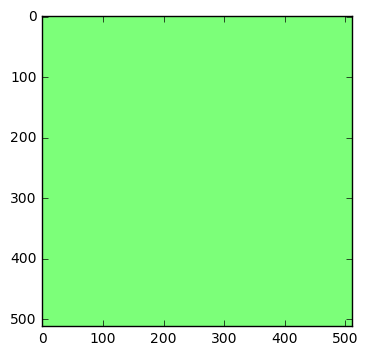

3
1
1


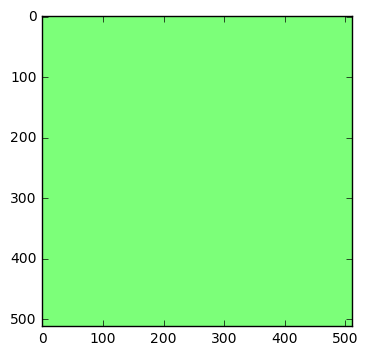

3
1
1


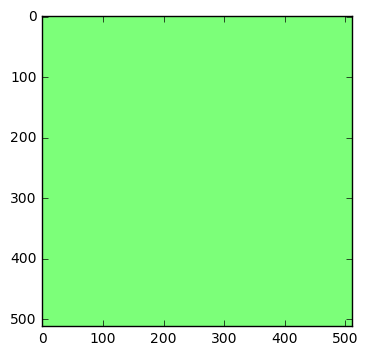

3
1
1


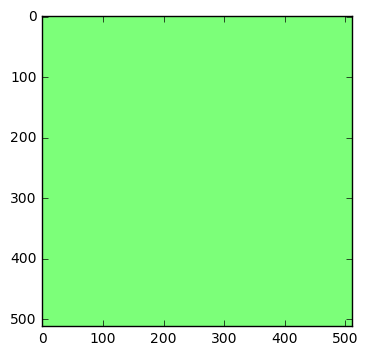

3
1
1


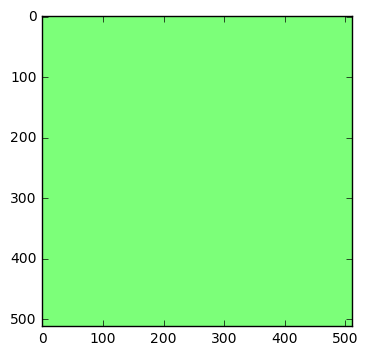

3
1
1


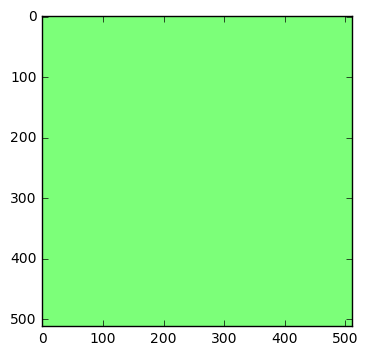

3
1
1


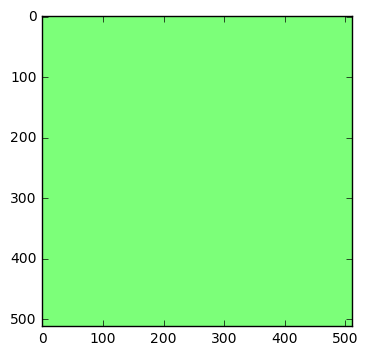

3
1
1


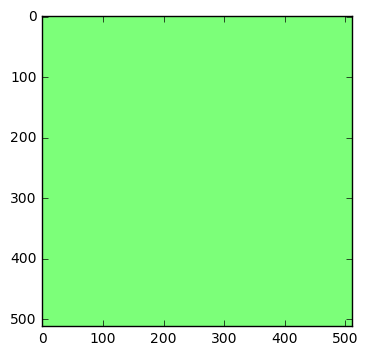

3
1
1


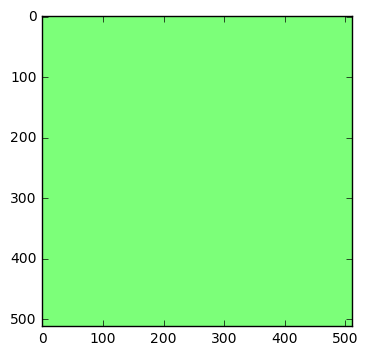

3
1
1


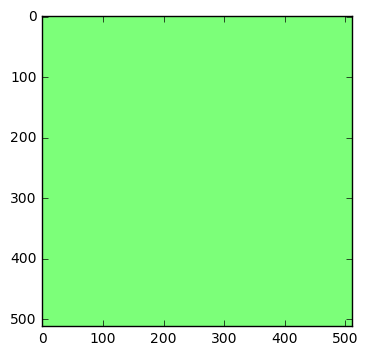

3
1
1


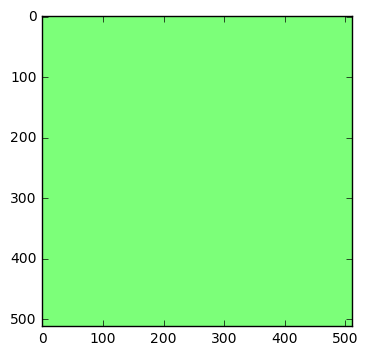

3
1
1


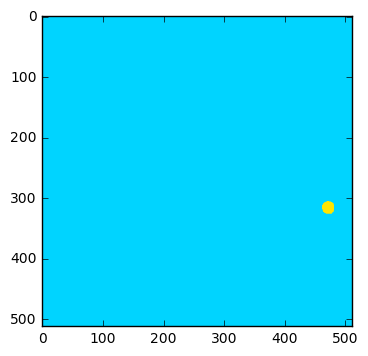

4
1
345
1


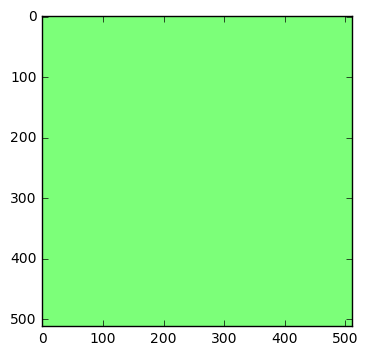

3
1
1


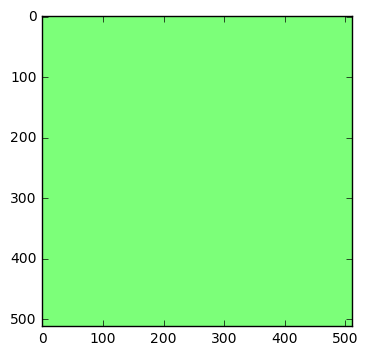

3
1
1


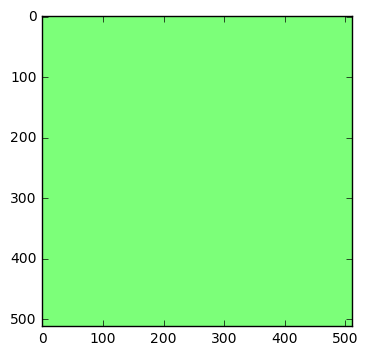

3
1
1


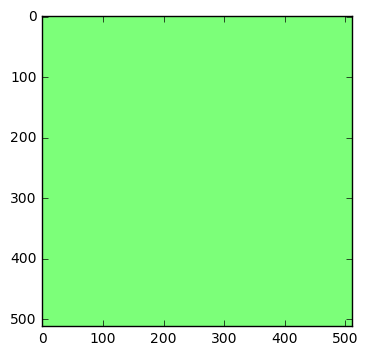

3
1
1


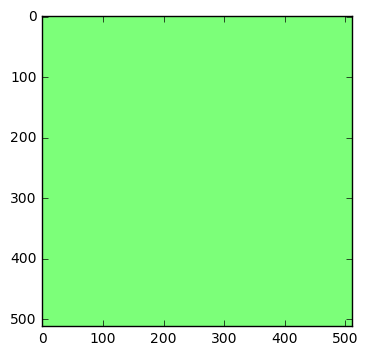

3
1
1


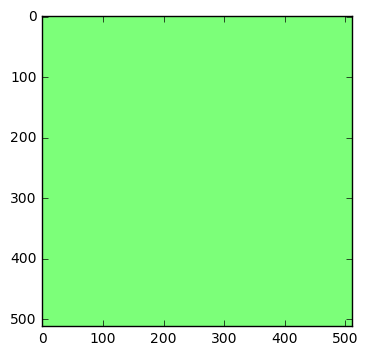

3
1
1


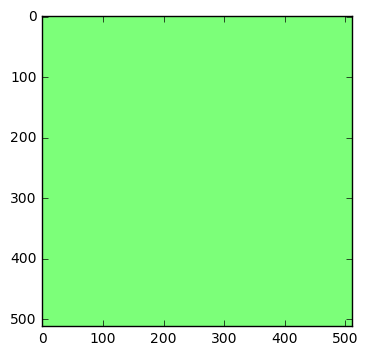

3
1
1


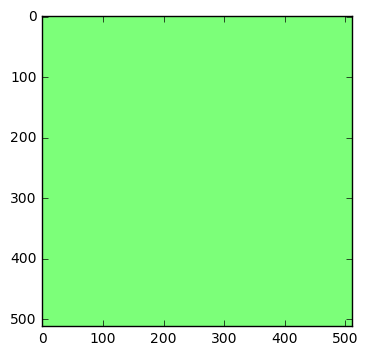

3
1
1


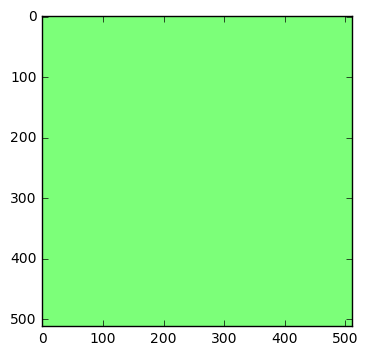

3
1
1


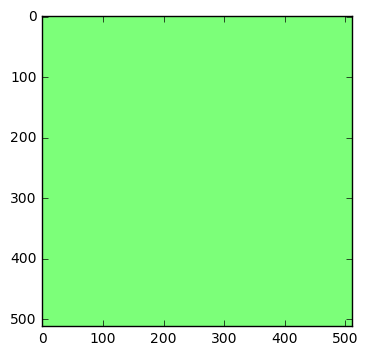

3
1
1


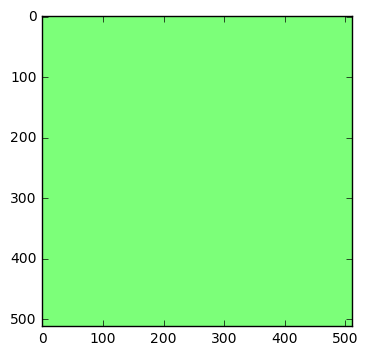

3
1
1


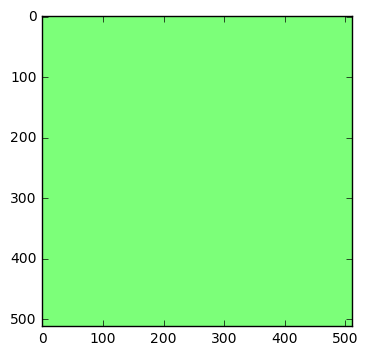

3
1
1


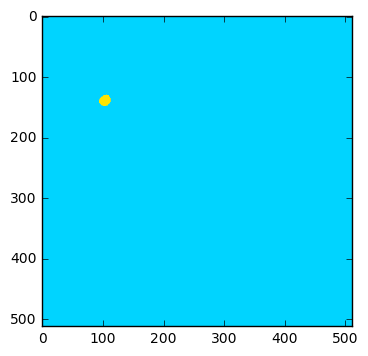

4
1
274
1


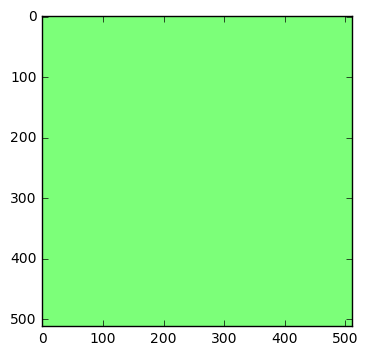

3
1
1


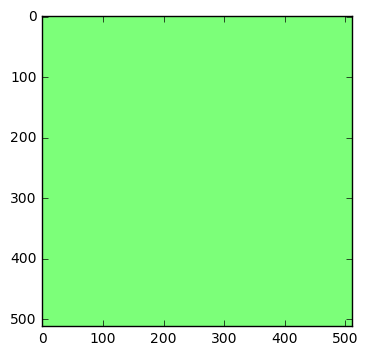

3
1
1


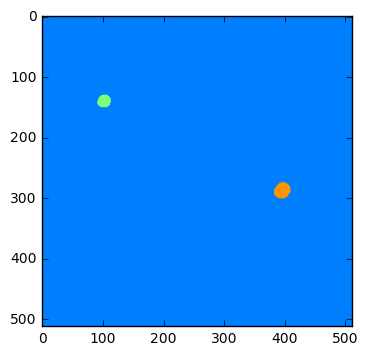

5
1
376
563
1


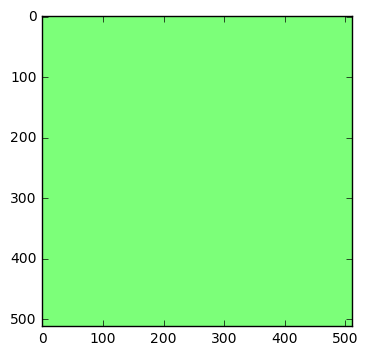

3
1
1


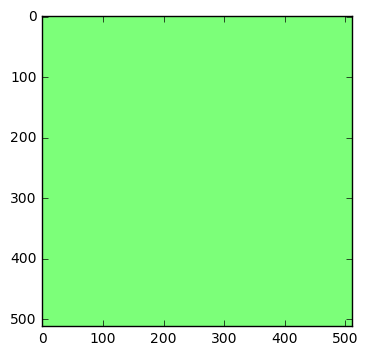

3
1
1


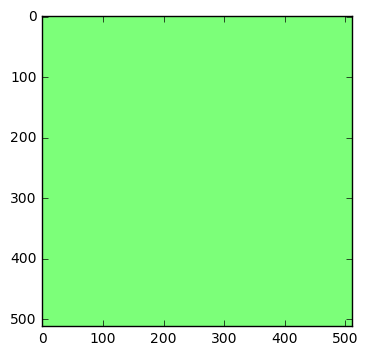

3
1
1


4
1
234
1


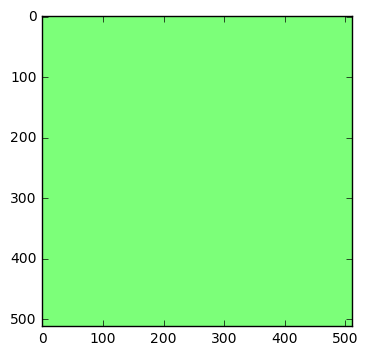

3
1
1


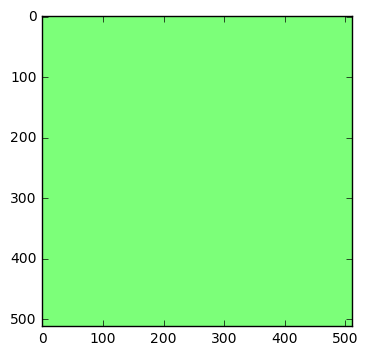

3
1
1


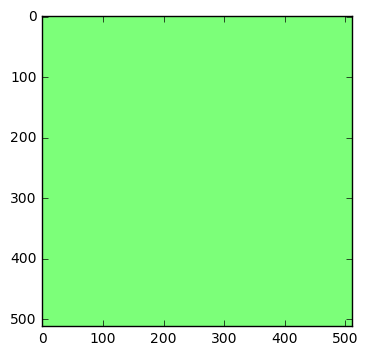

3
1
1


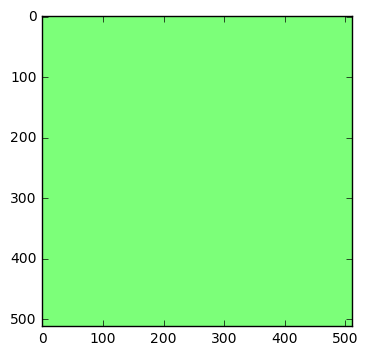

3
1
1


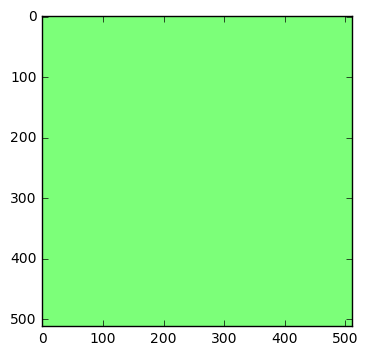

3
1
1


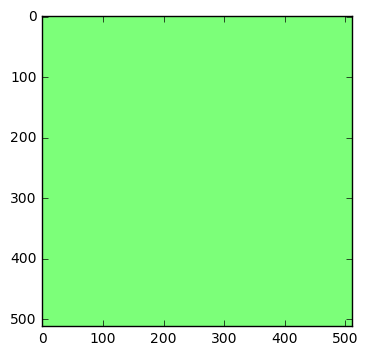

3
1
1


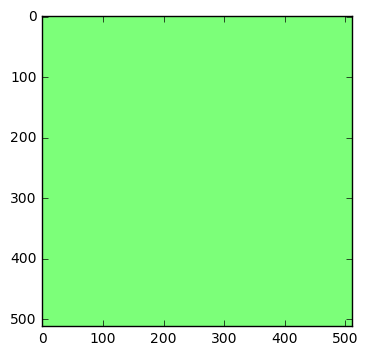

3
1
1


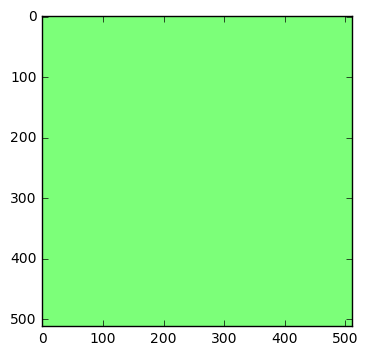

3
1
1


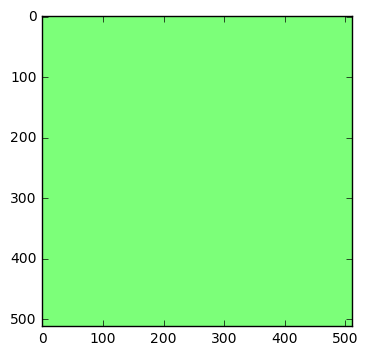

3
1
1


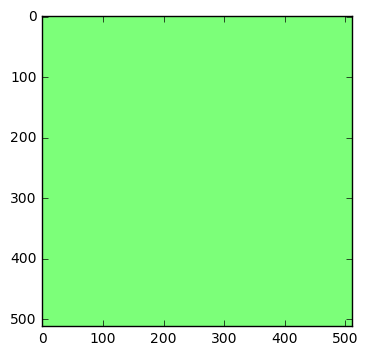

3
1
1


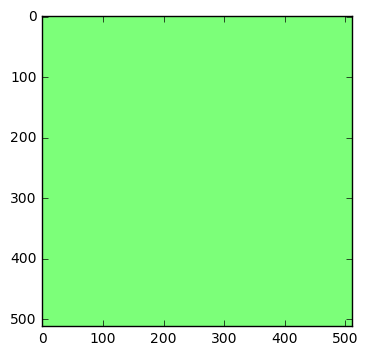

3
1
1


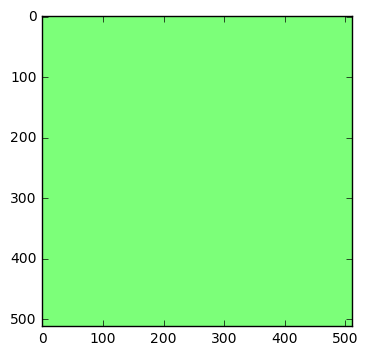

3
1
1


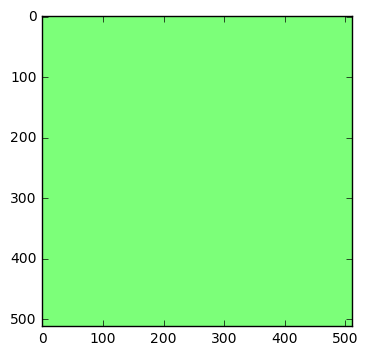

3
1
1


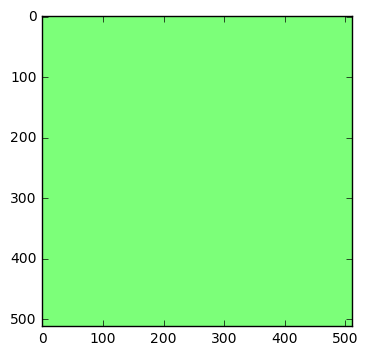

3
1
1


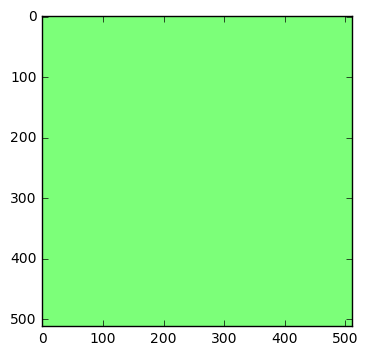

3
1
1


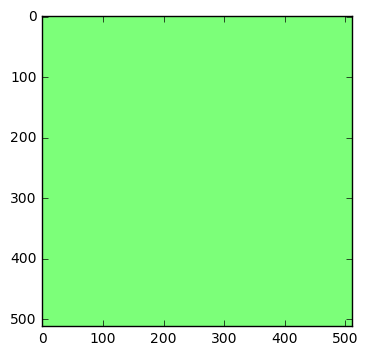

3
1
1


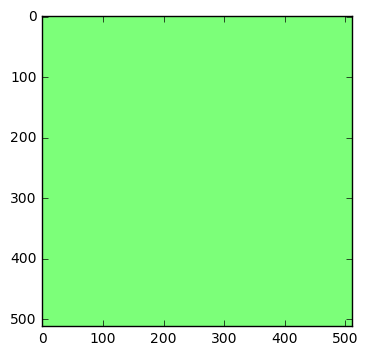

3
1
1


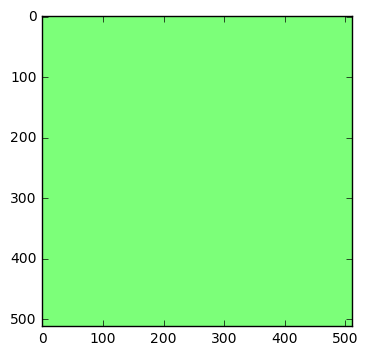

3
1
1


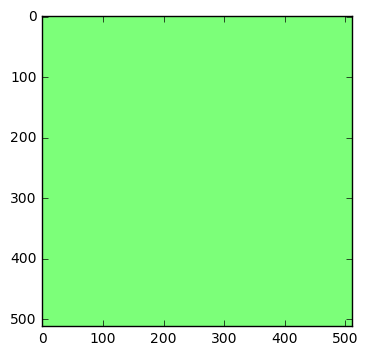

3
1
1


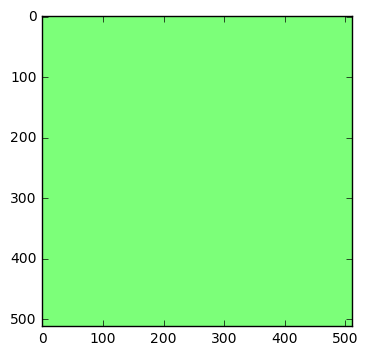

3
1
1


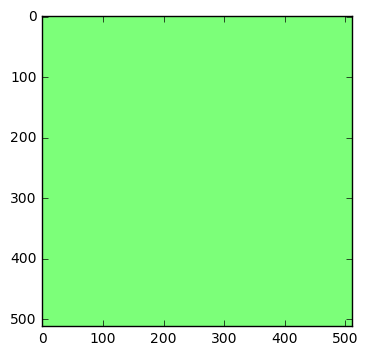

3
1
1


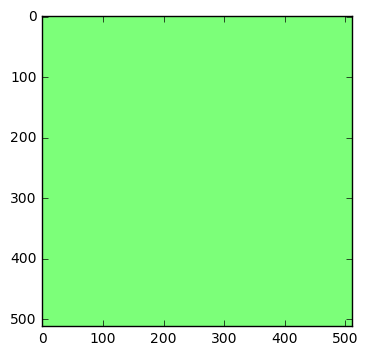

3
1
1


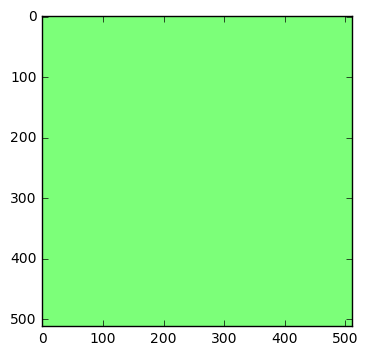

3
1
1


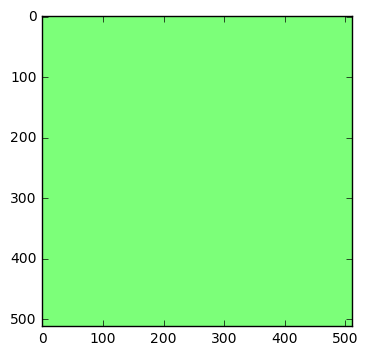

3
1
1


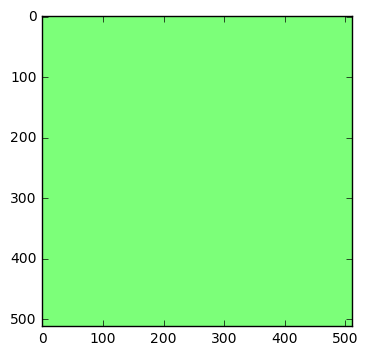

3
1
1


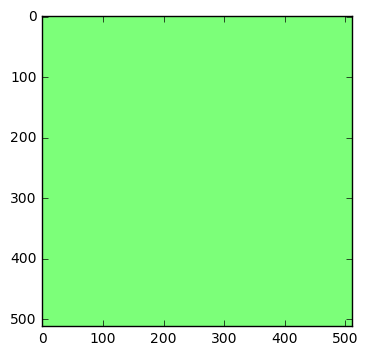

3
1
1


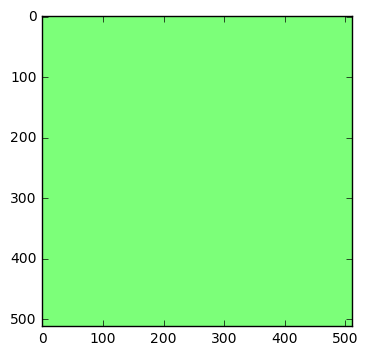

3
1
1


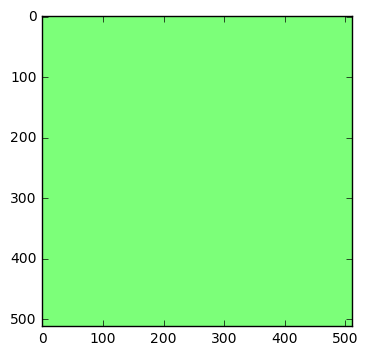

3
1
1


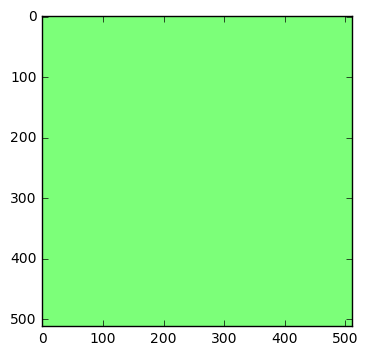

3
1
1


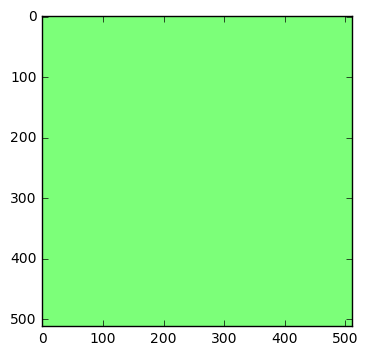

3
1
1


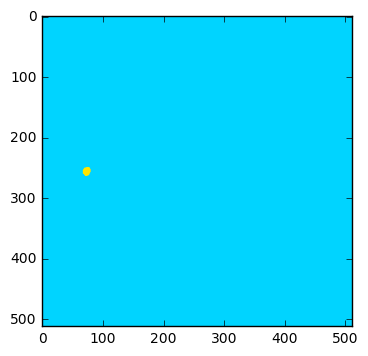

4
1
153
1


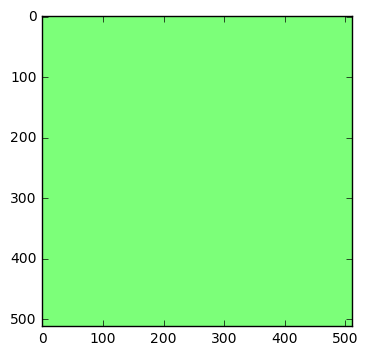

3
1
1


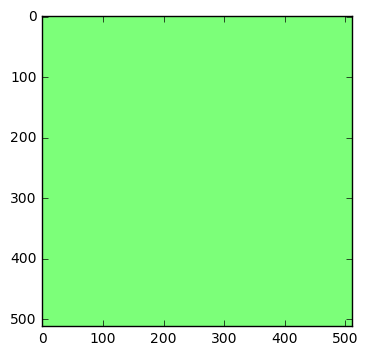

3
1
1


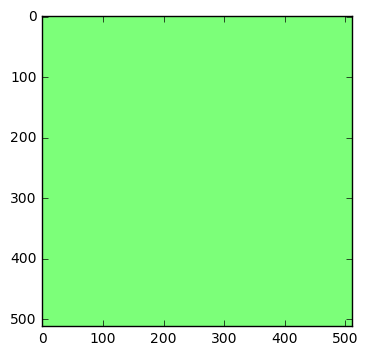

3
1
1


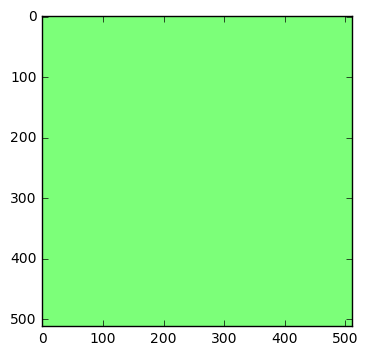

3
1
1


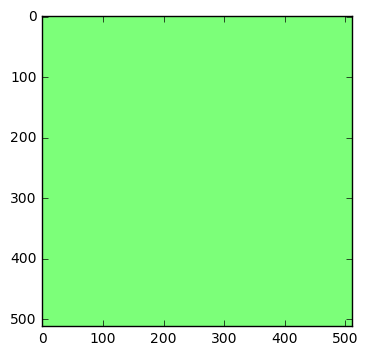

3
1
1


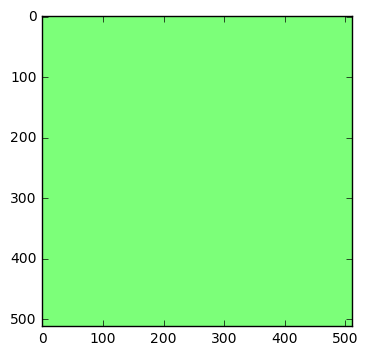

3
1
1


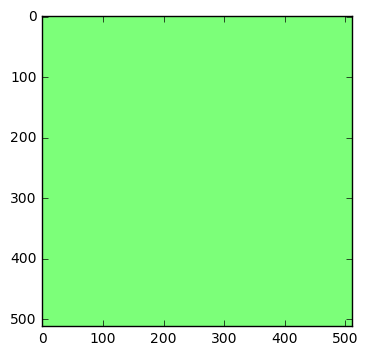

3
1
1


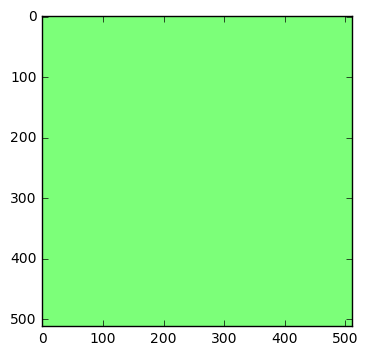

3
1
1


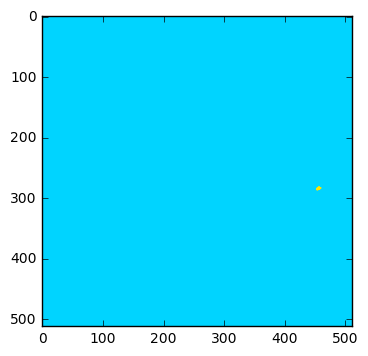

4
1
46
1


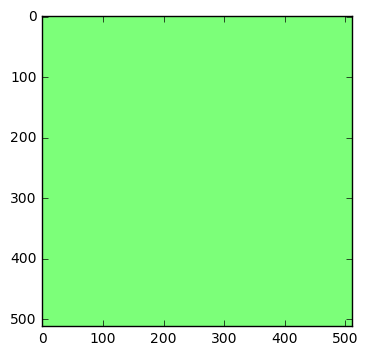

3
1
1


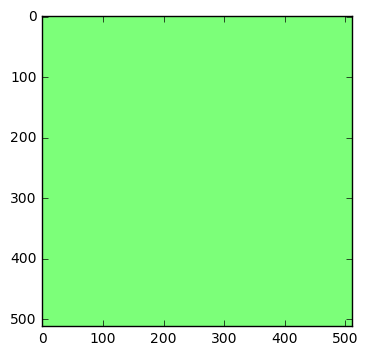

3
1
1


4
1
329
1


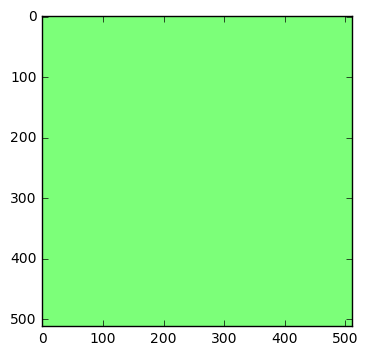

3
1
1


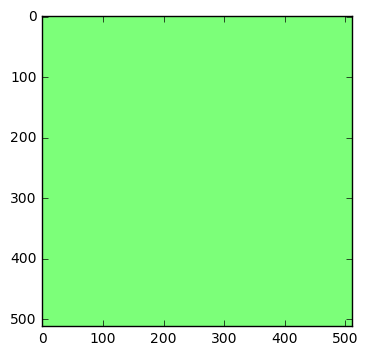

3
1
1


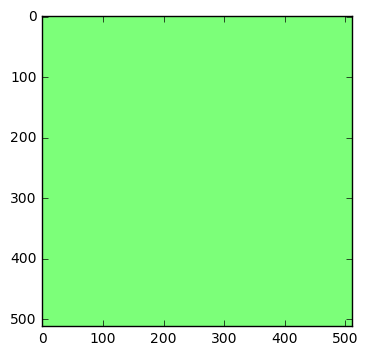

3
1
1


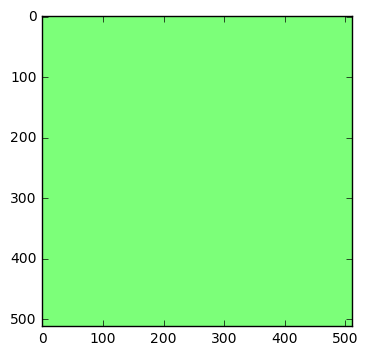

3
1
1


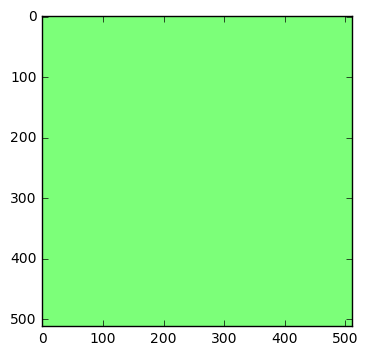

3
1
1


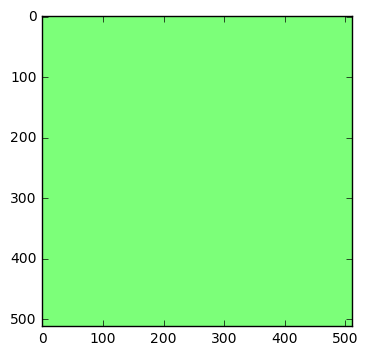

3
1
1


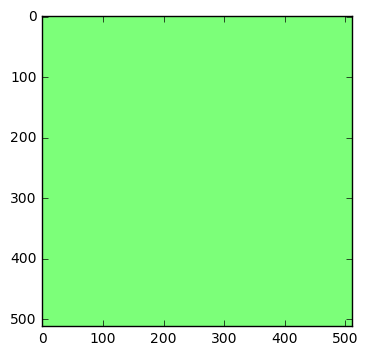

3
1
1


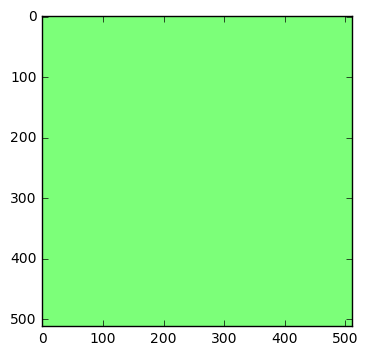

3
1
1


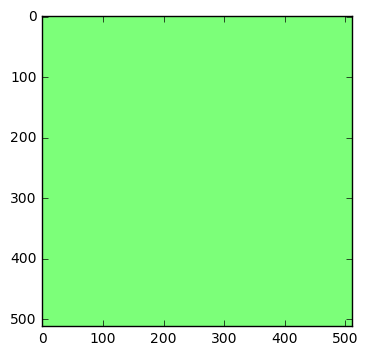

3
1
1


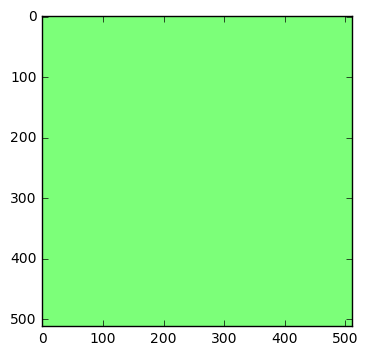

3
1
1


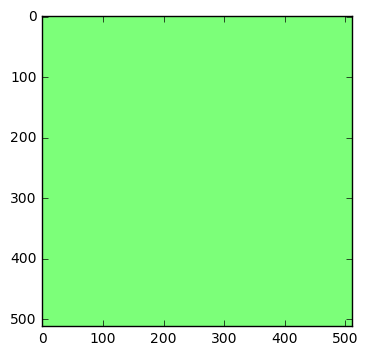

3
1
1


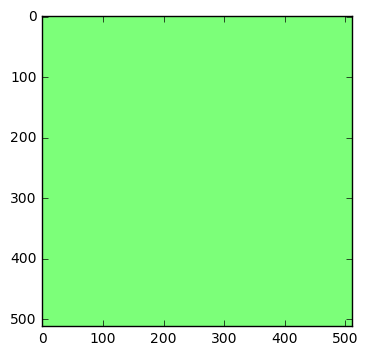

3
1
1


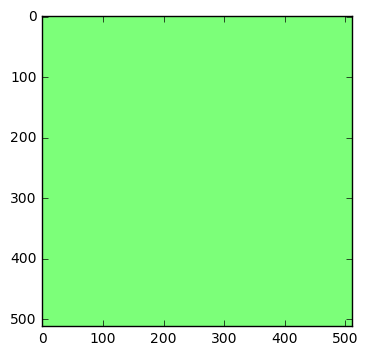

3
1
1


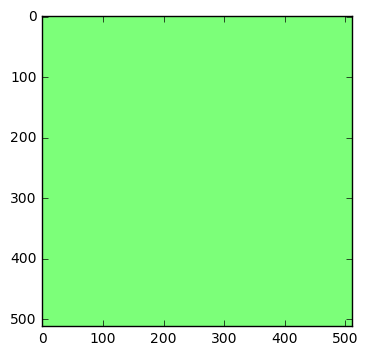

3
1
1


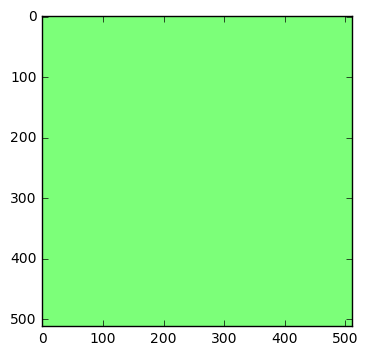

3
1
1


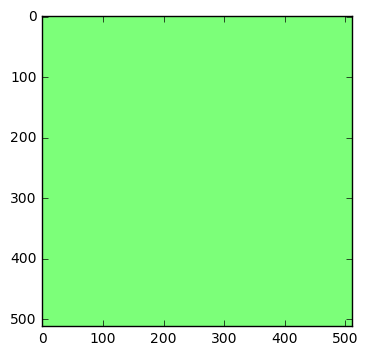

3
1
1


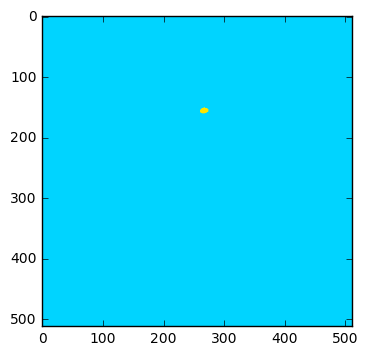

4
1
105
1


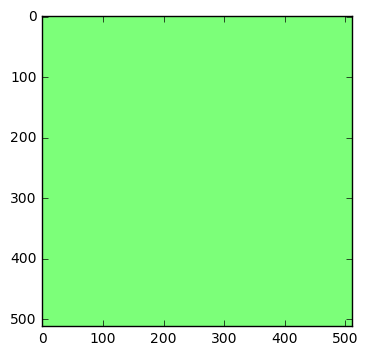

3
1
1


4
1
848
1


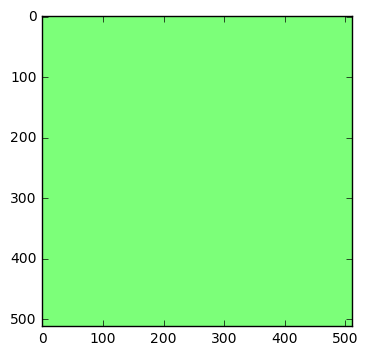

3
1
1


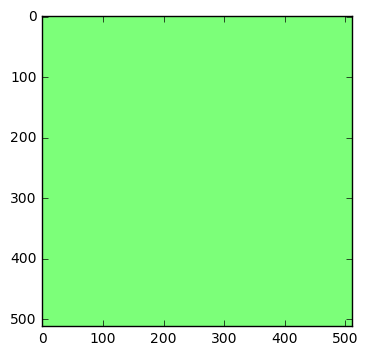

3
1
1


4
1
560
1


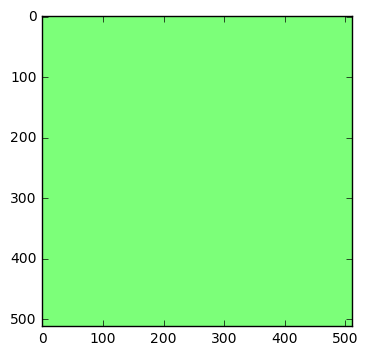

3
1
1


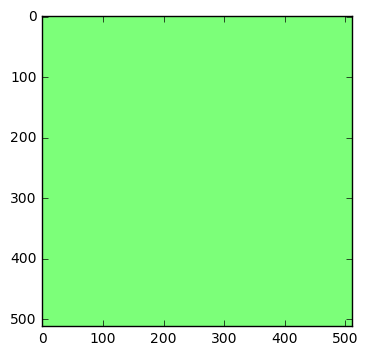

3
1
1


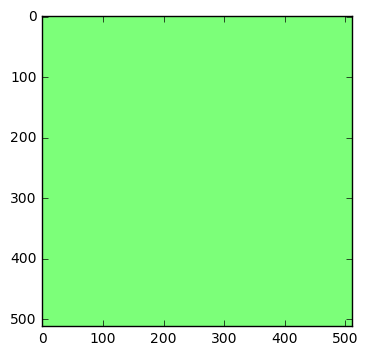

3
1
1


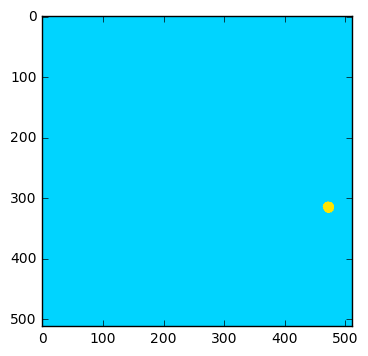

4
1
277
1


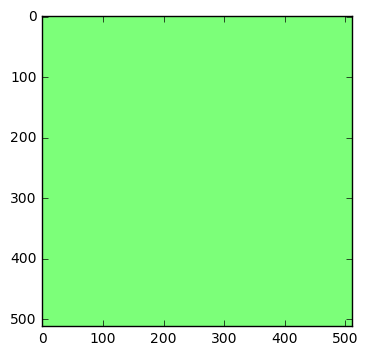

3
1
1


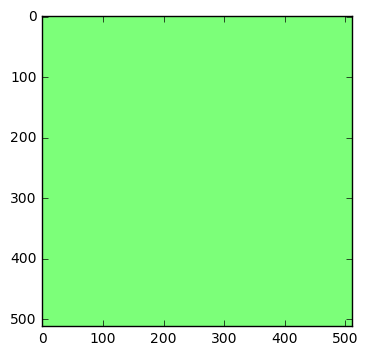

3
1
1


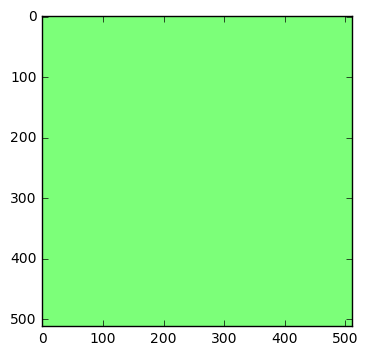

3
1
1


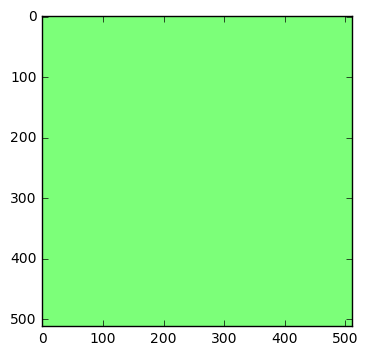

3
1
1


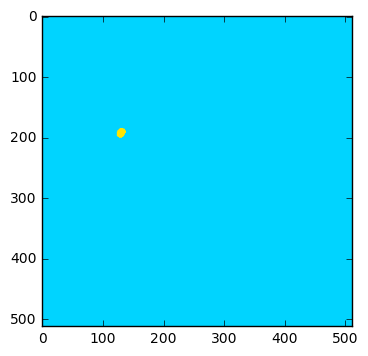

4
1
186
1


5
1
316
287
1


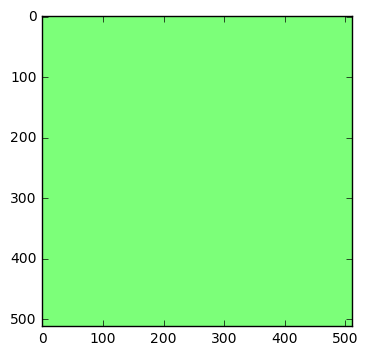

3
1
1


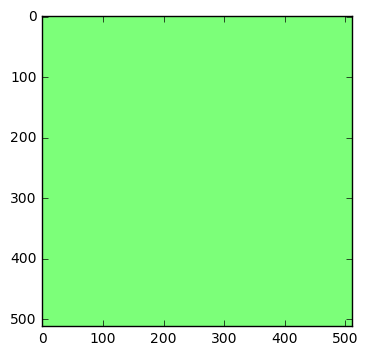

3
1
1


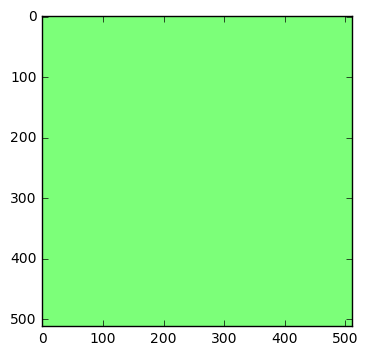

3
1
1


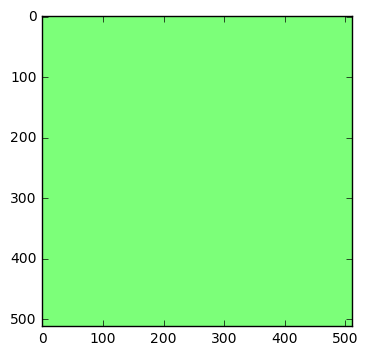

3
1
1


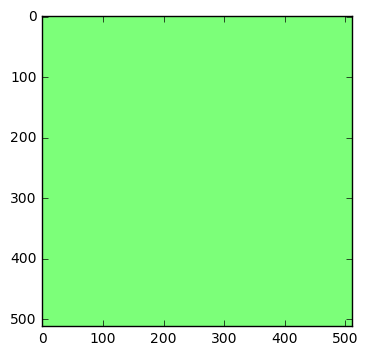

3
1
1


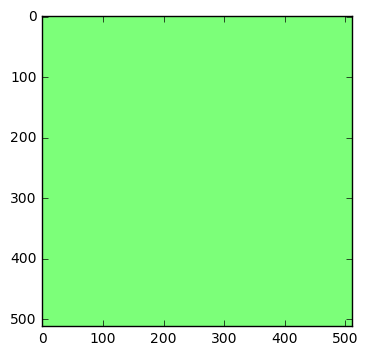

3
1
1


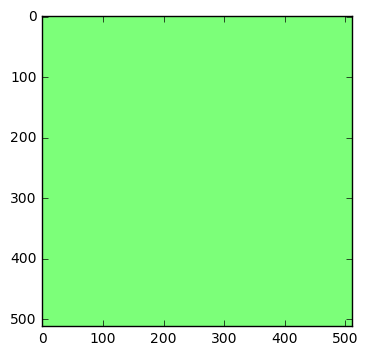

3
1
1


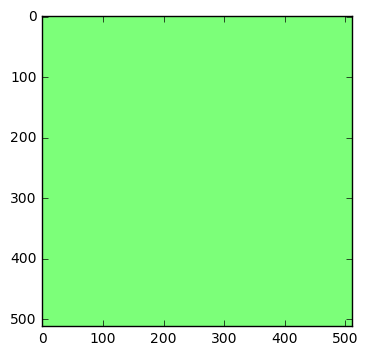

3
1
1


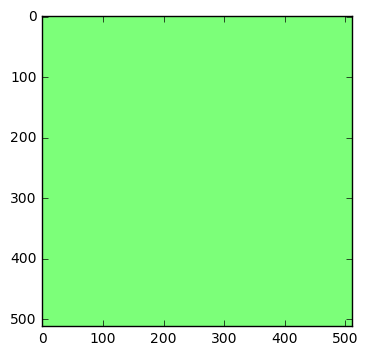

3
1
1


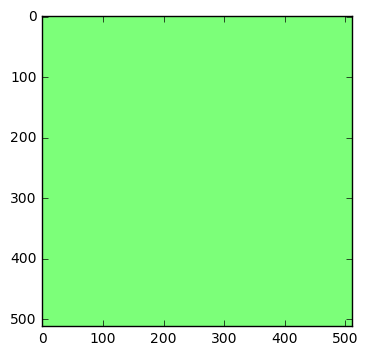

3
1
1


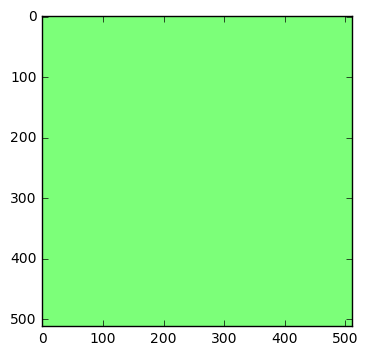

3
1
1


4
1
281
1


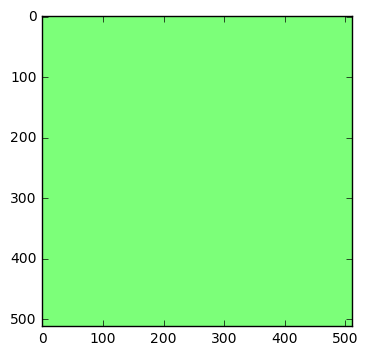

3
1
1


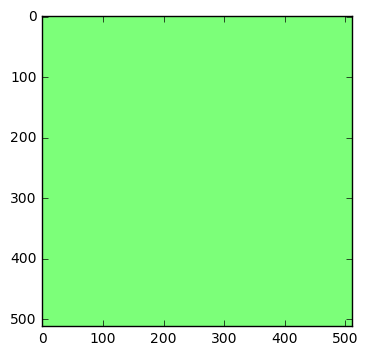

3
1
1


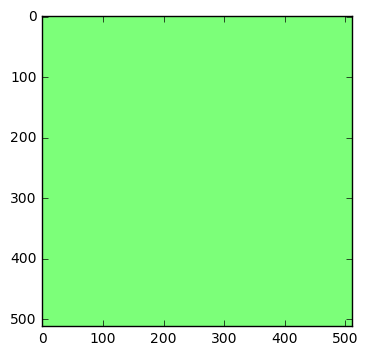

3
1
1


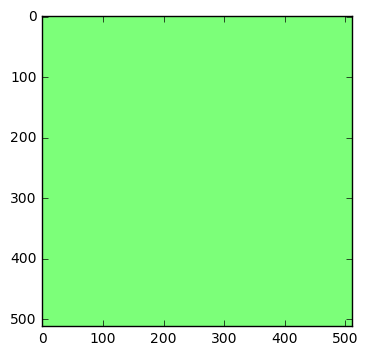

3
1
1


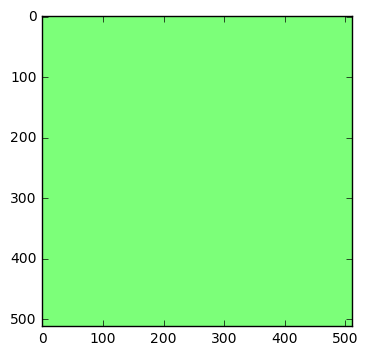

3
1
1


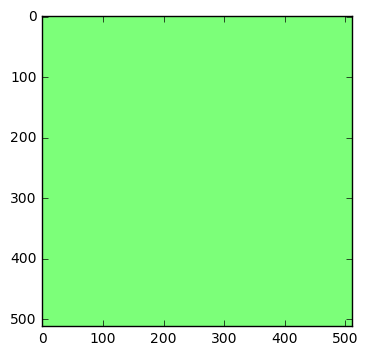

3
1
1


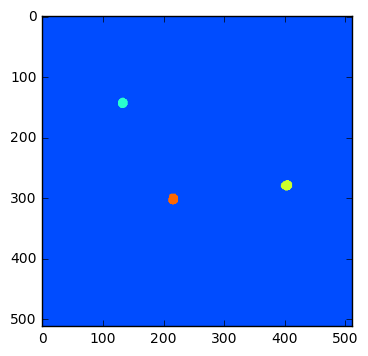

6
1
221
250
242
1


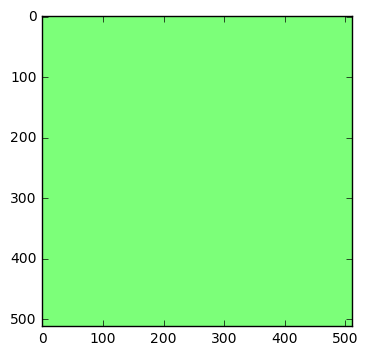

3
1
1


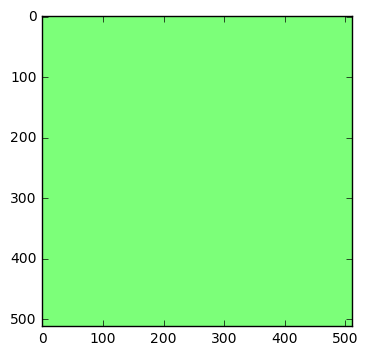

3
1
1


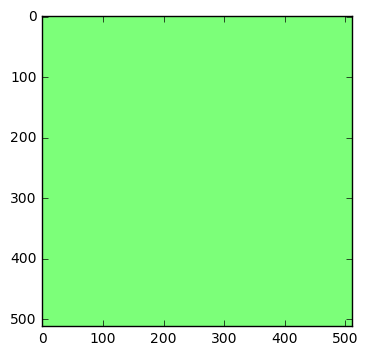

3
1
1


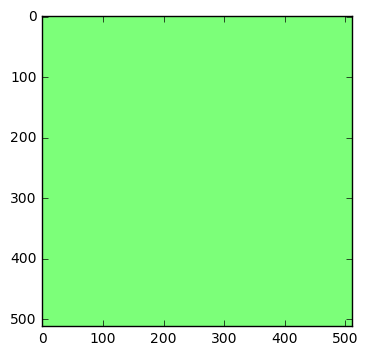

3
1
1


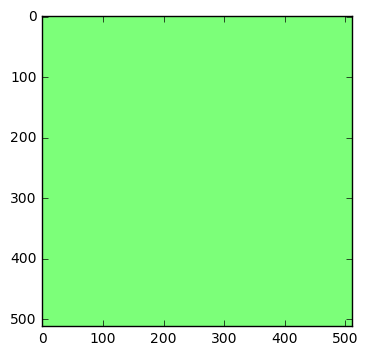

3
1
1


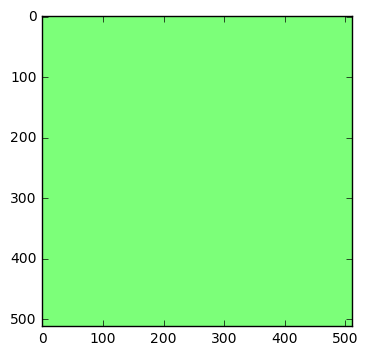

3
1
1


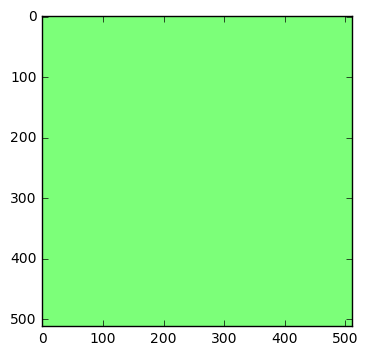

3
1
1


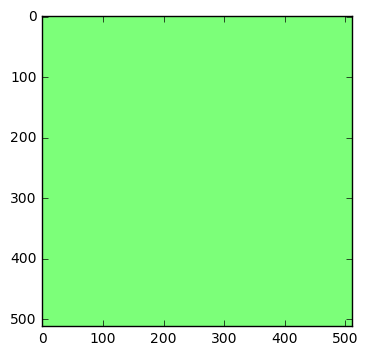

3
1
1


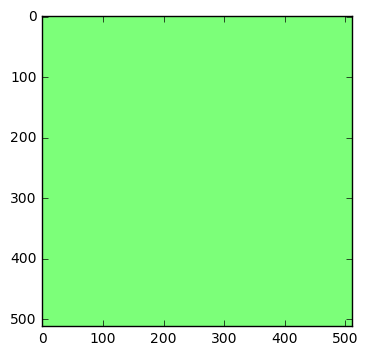

3
1
1


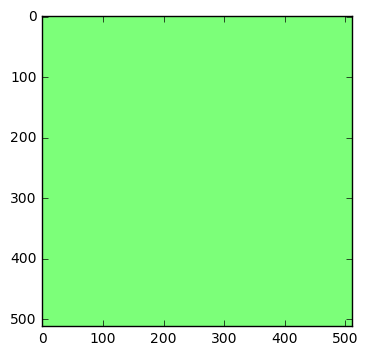

3
1
1


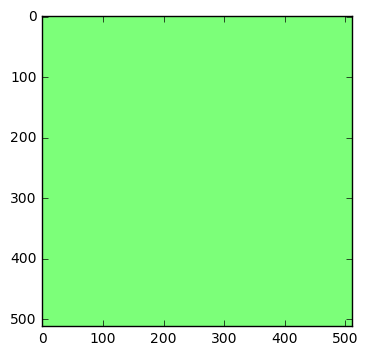

3
1
1


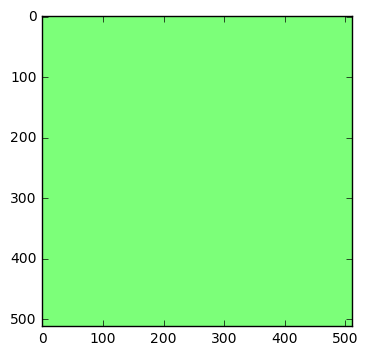

3
1
1


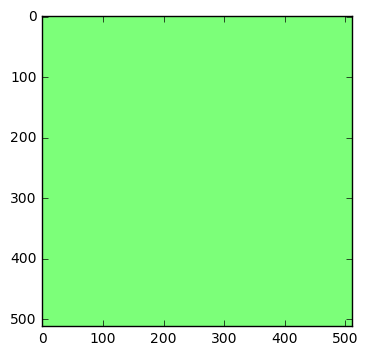

3
1
1


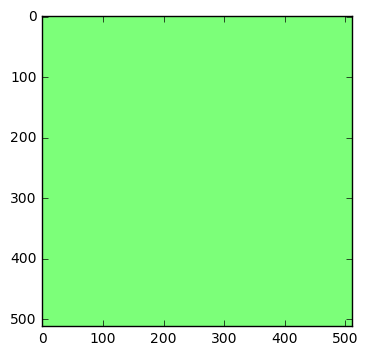

3
1
1


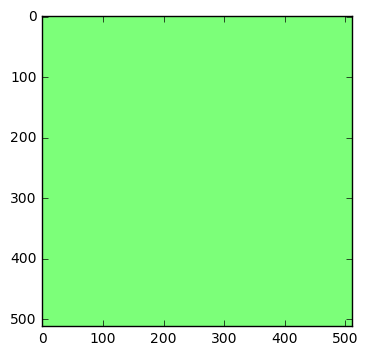

3
1
1


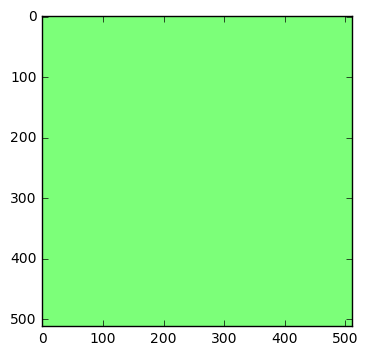

3
1
1


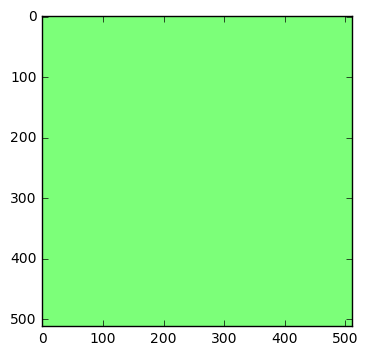

3
1
1


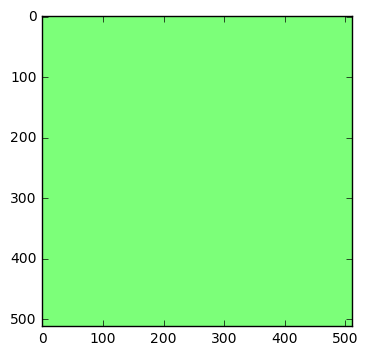

3
1
1


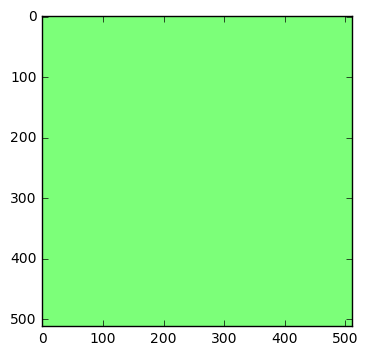

3
1
1


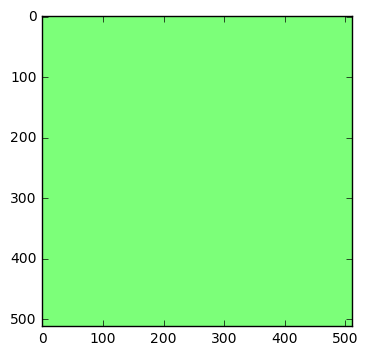

3
1
1


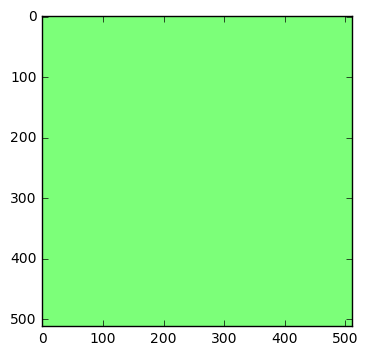

3
1
1


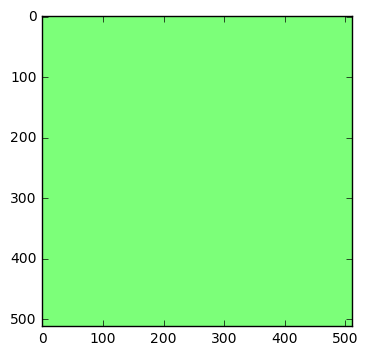

3
1
1


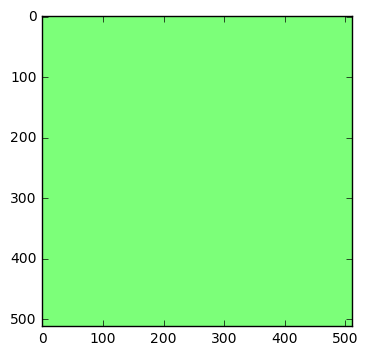

3
1
1


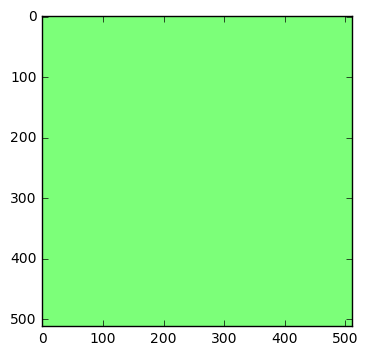

3
1
1


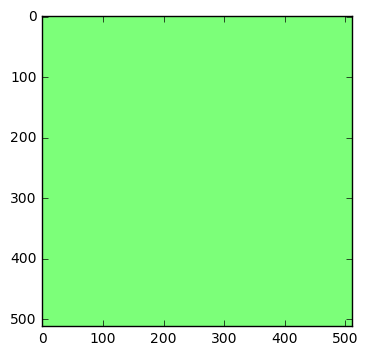

3
1
1


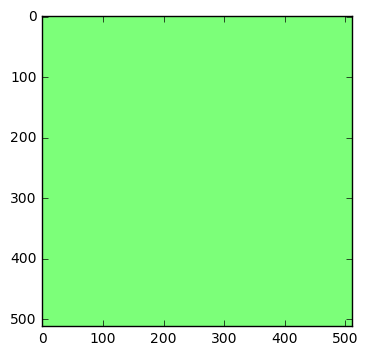

3
1
1


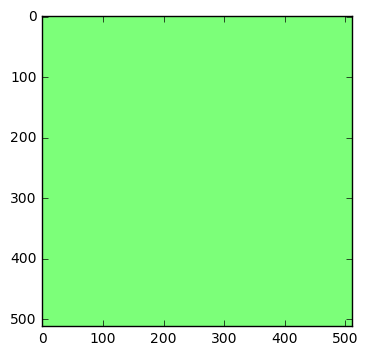

3
1
1


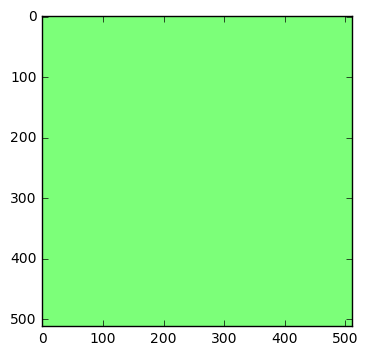

3
1
1


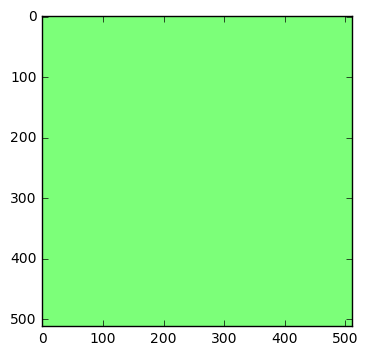

3
1
1


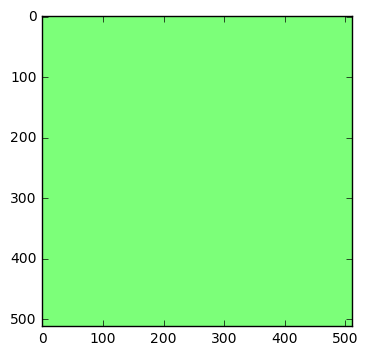

3
1
1


4
1
356
1


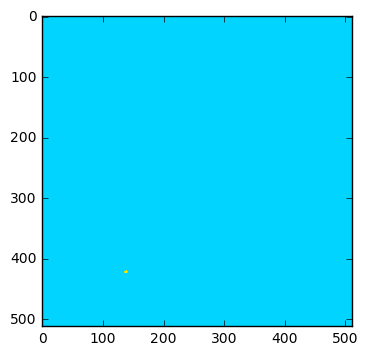

4
1
23
1


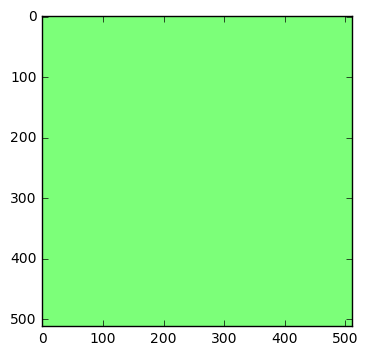

3
1
1


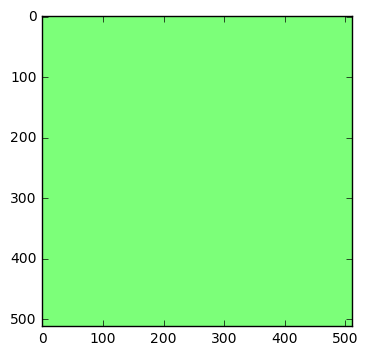

3
1
1


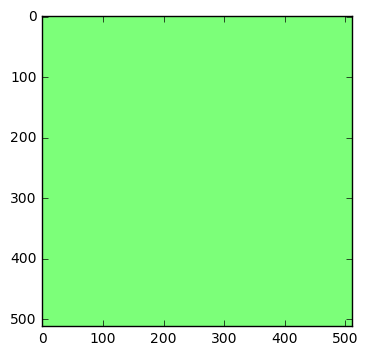

3
1
1


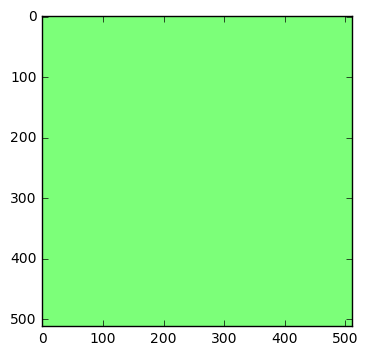

3
1
1


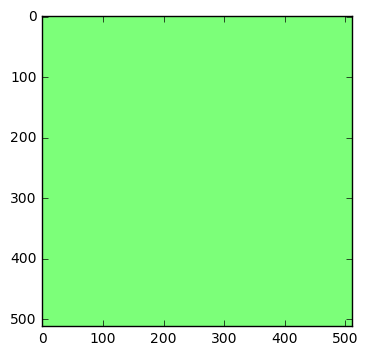

3
1
1


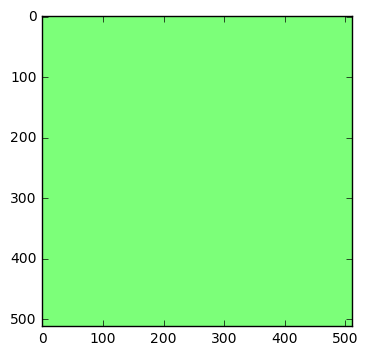

3
1
1


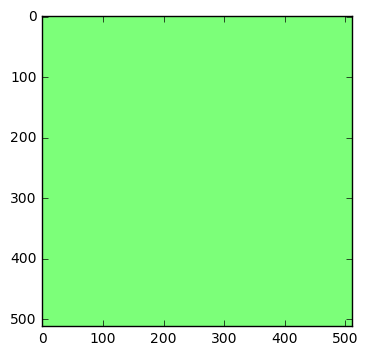

  0%|          | 1/1397 [00:34<13:22:20, 34.48s/it]

3
1
1


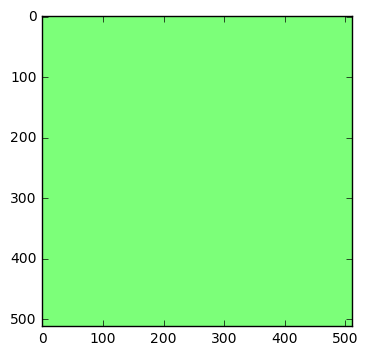

3
1
1


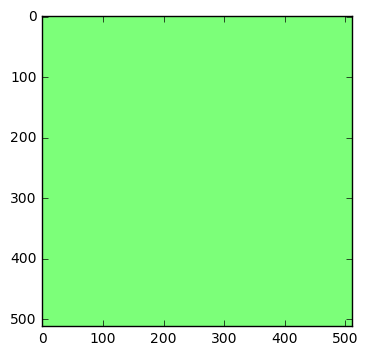

3
1
1


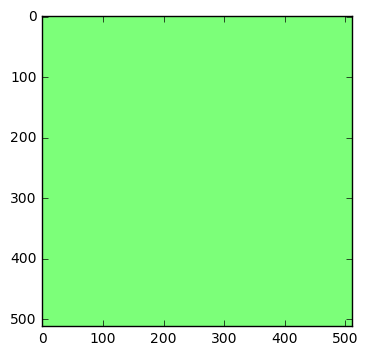

3
1
1


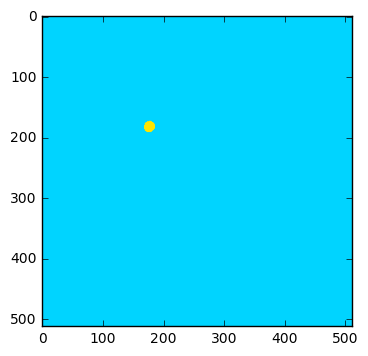

4
1
268
1


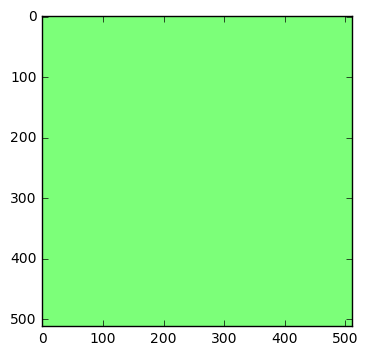

3
1
1


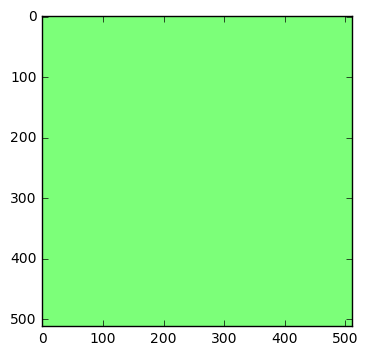

3
1
1


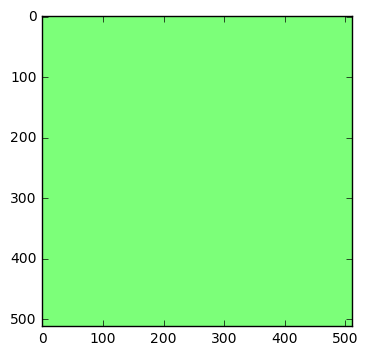

3
1
1


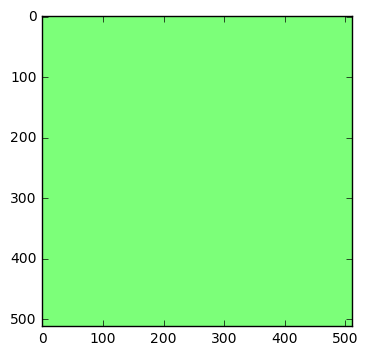

3
1
1


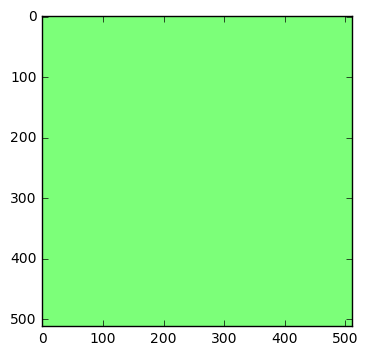

3
1
1


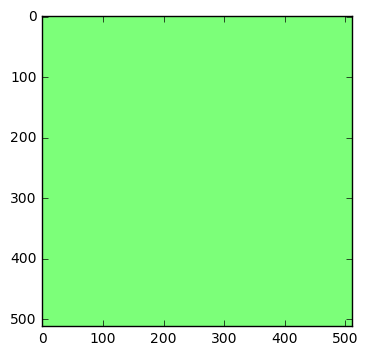

3
1
1


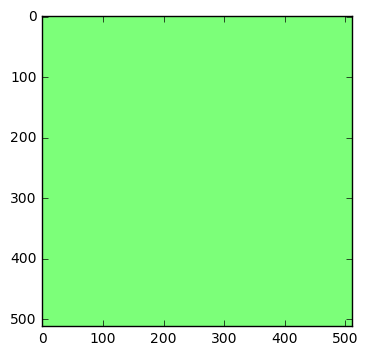

3
1
1


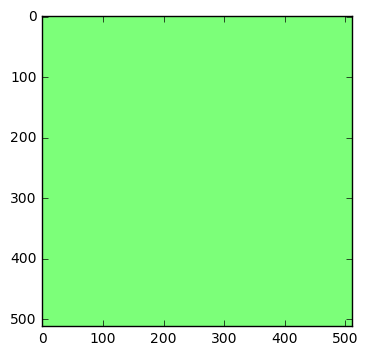

3
1
1


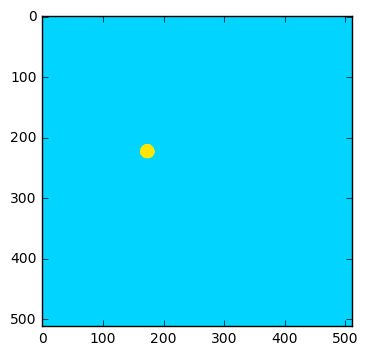

4
1
459
1


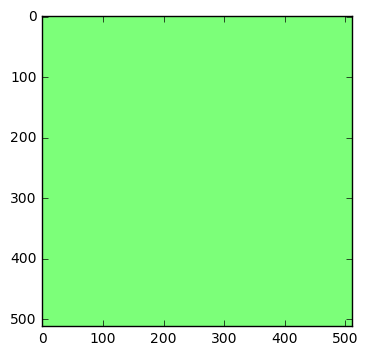

3
1
1


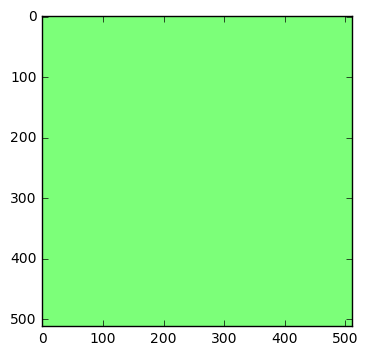

3
1
1


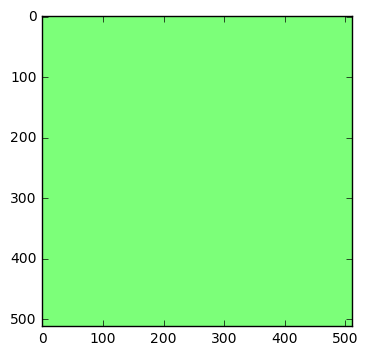

3
1
1


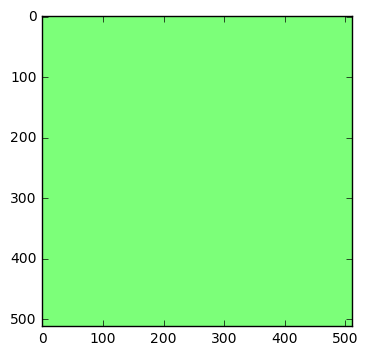

3
1
1


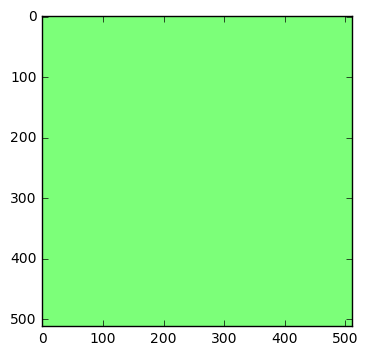

3
1
1


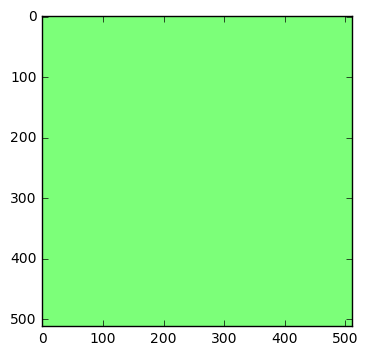

3
1
1


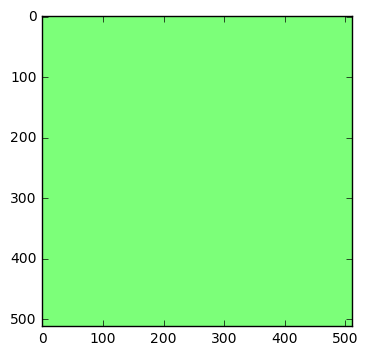

3
1
1


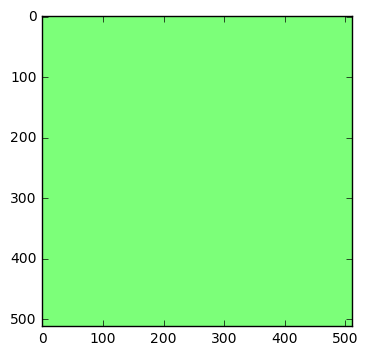

3
1
1


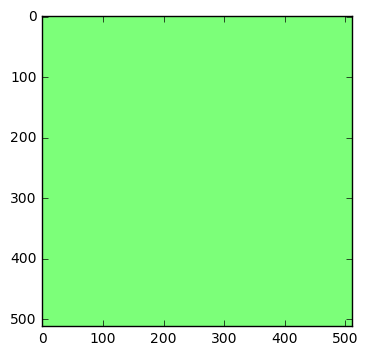

3
1
1


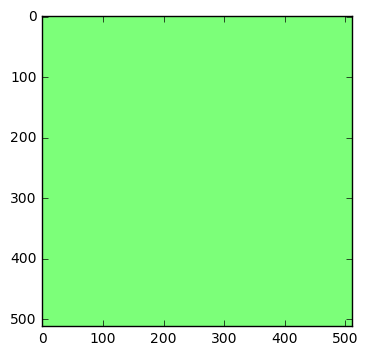

3
1
1


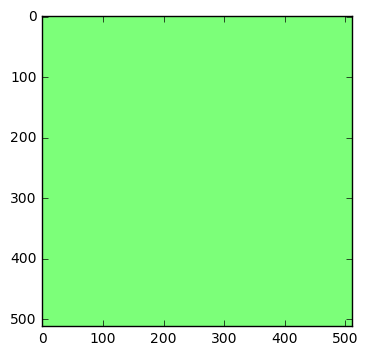

3
1
1


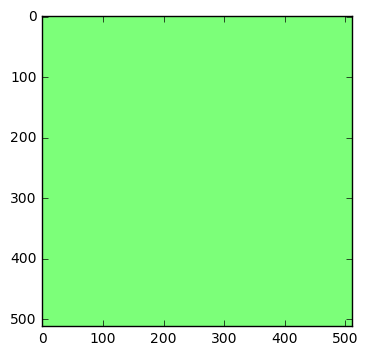

3
1
1


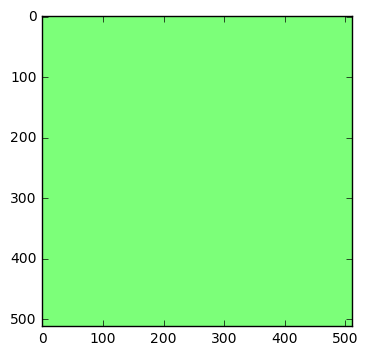

3
1
1


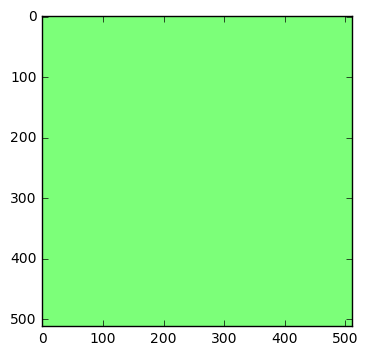

3
1
1


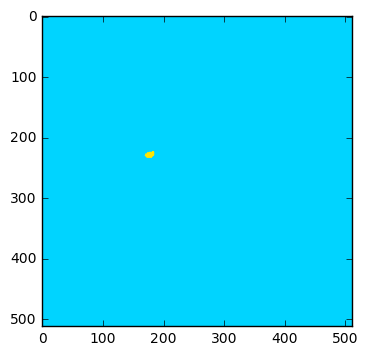

4
1
130
1


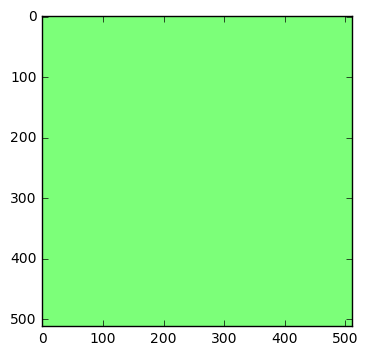

3
1
1


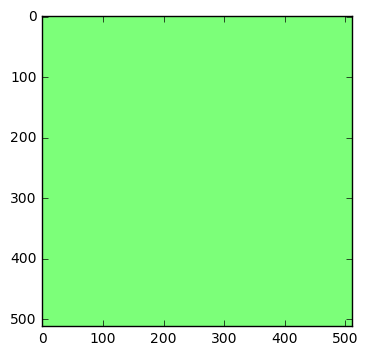

3
1
1


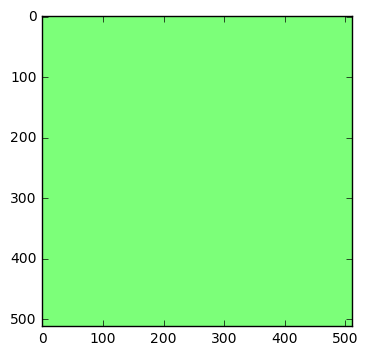

3
1
1


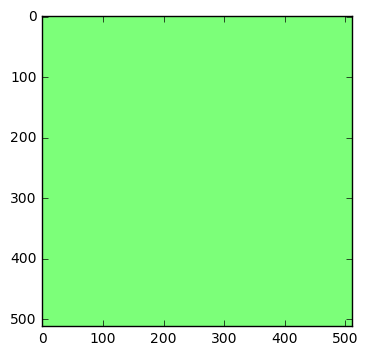

3
1
1


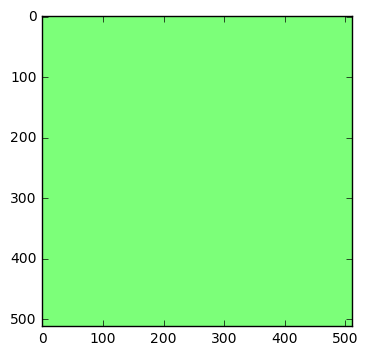

3
1
1


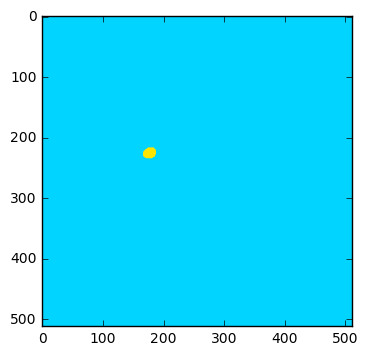

4
1
321
1


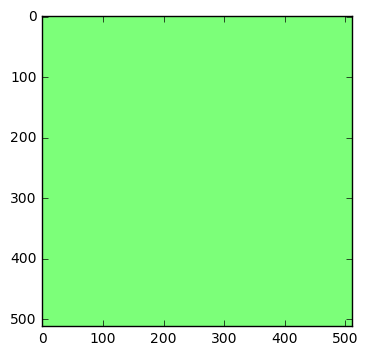

3
1
1


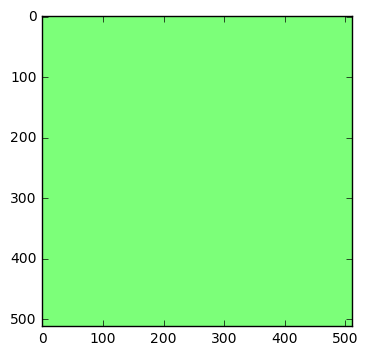

3
1
1


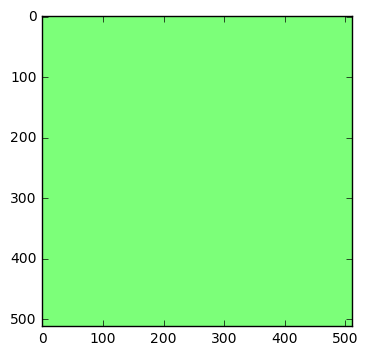

3
1
1


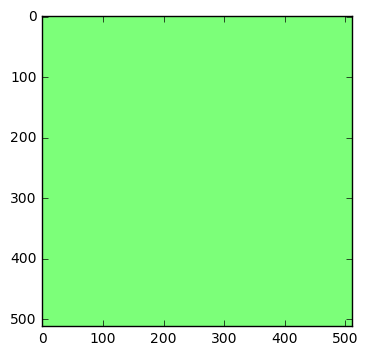

3
1
1


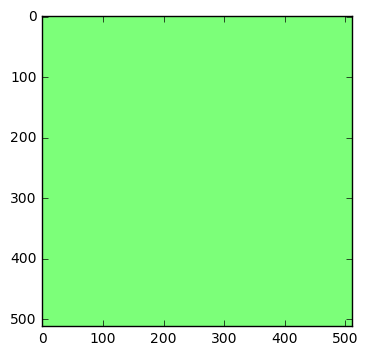

3
1
1


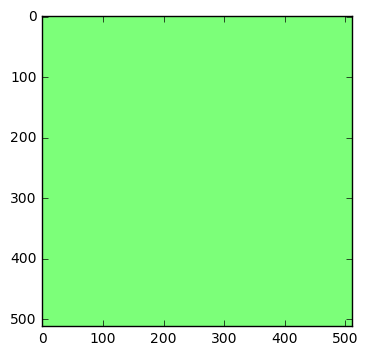

3
1
1


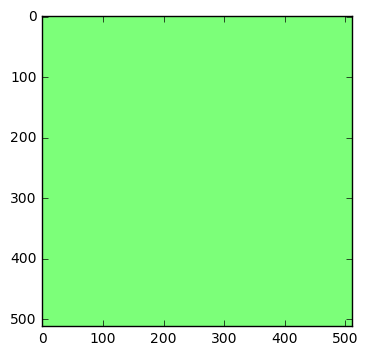

3
1
1


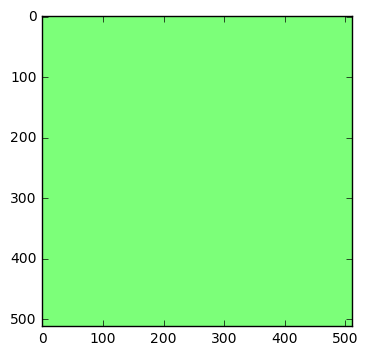

3
1
1


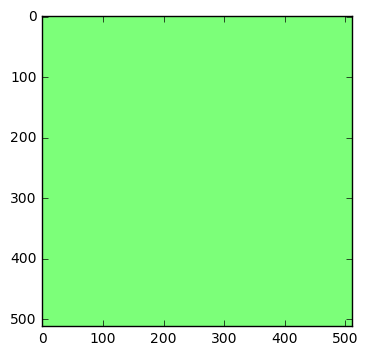

3
1
1


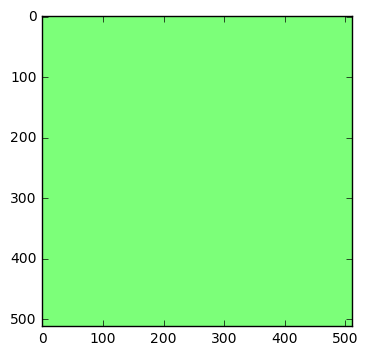

3
1
1


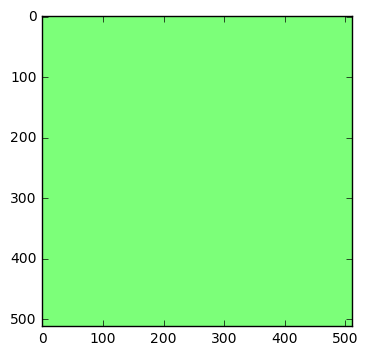

3
1
1


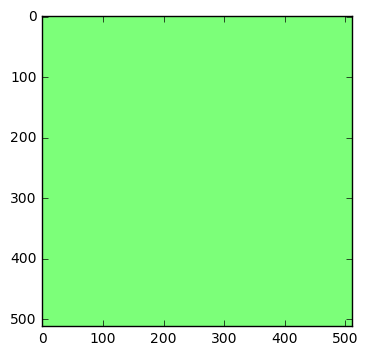

3
1
1


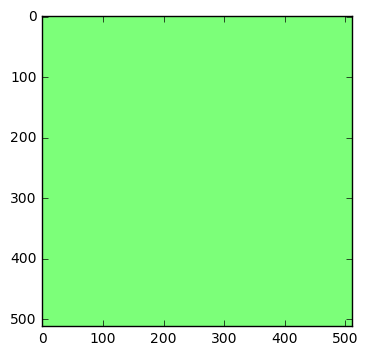

3
1
1


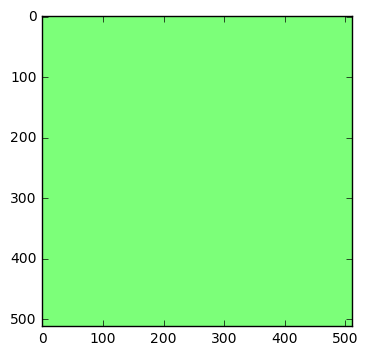

3
1
1


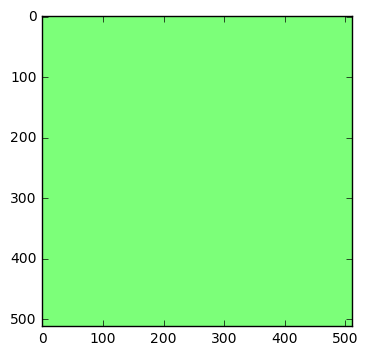

3
1
1


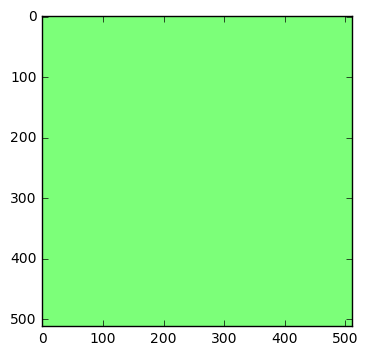

3
1
1


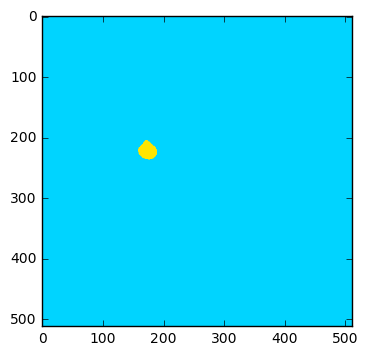

4
1
699
1


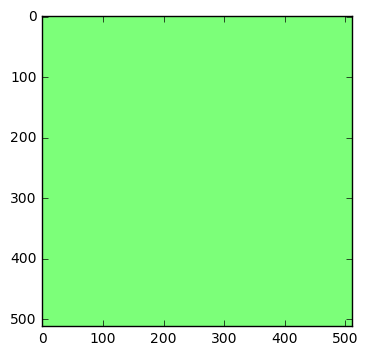

3
1
1


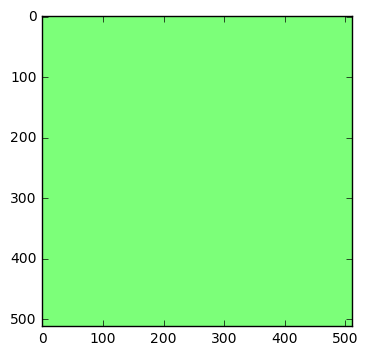

3
1
1


4
1
153
1


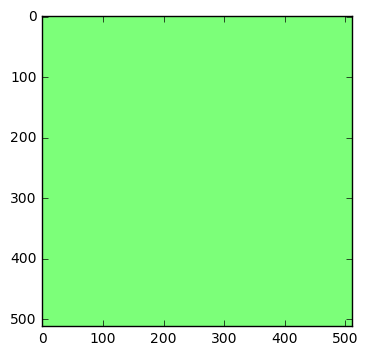

3
1
1


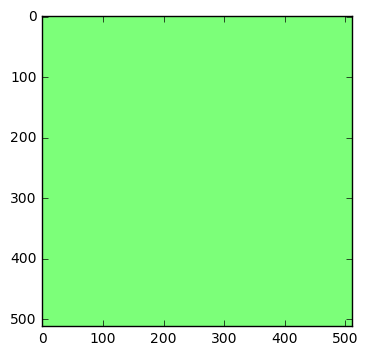

3
1
1


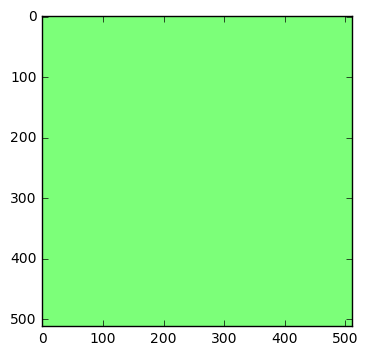

3
1
1


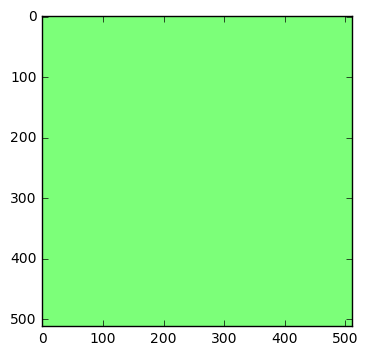

3
1
1


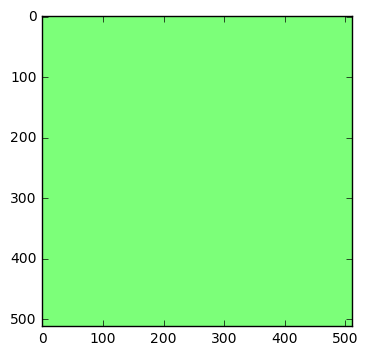

3
1
1


4
1
476
1


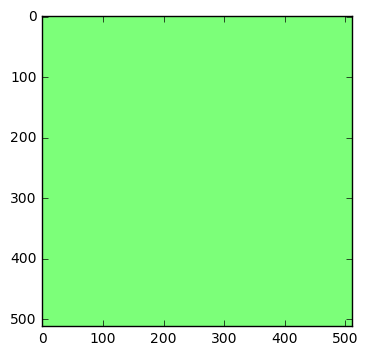

3
1
1


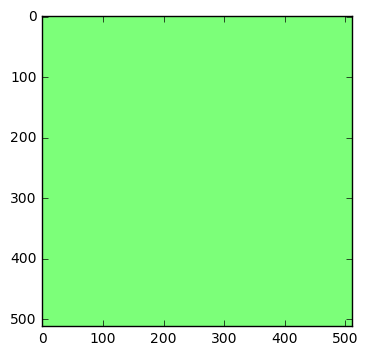

3
1
1


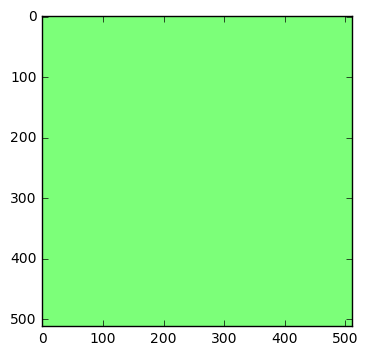

3
1
1


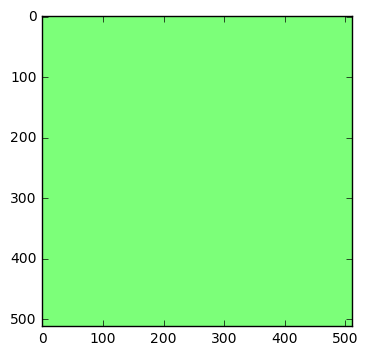

3
1
1


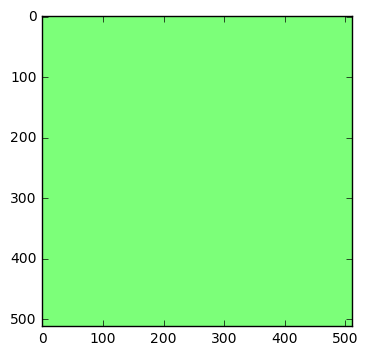

3
1
1


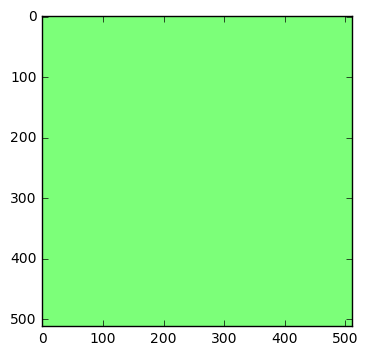

3
1
1


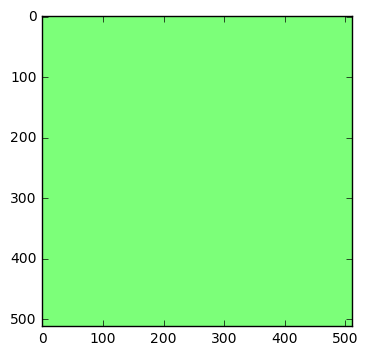

3
1
1


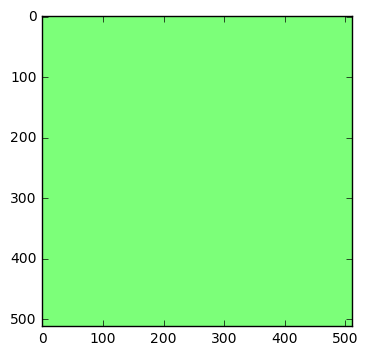

3
1
1


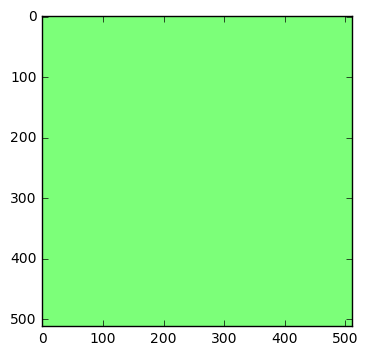

3
1
1


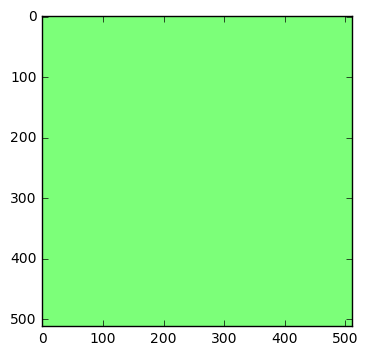

3
1
1


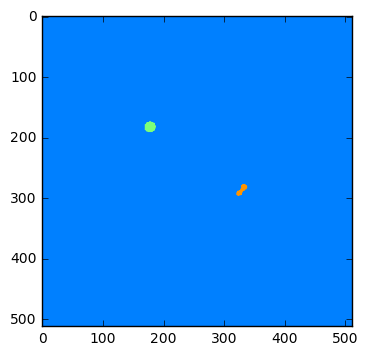

5
1
269
175
1


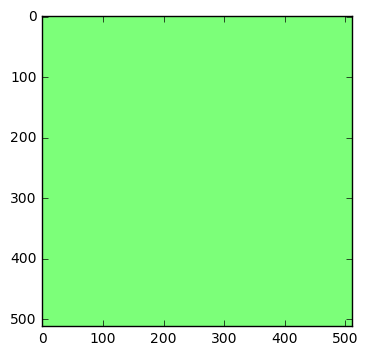

3
1
1


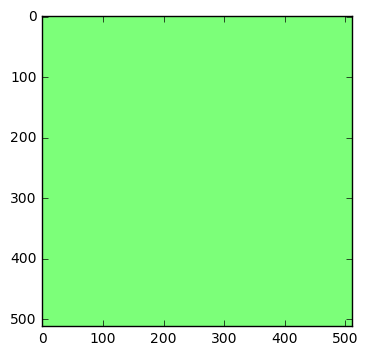

3
1
1


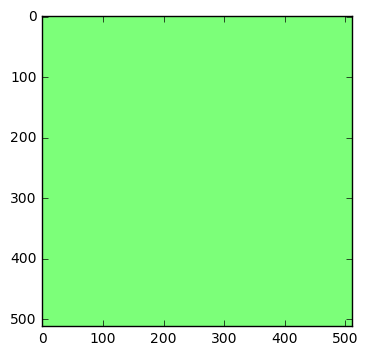

3
1
1


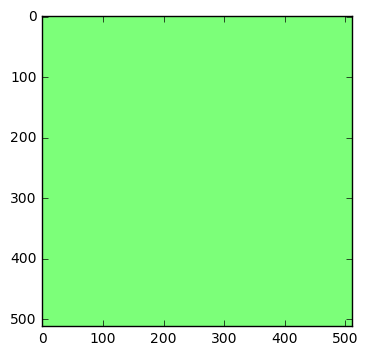

3
1
1


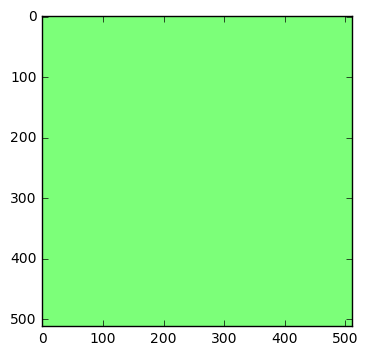

3
1
1


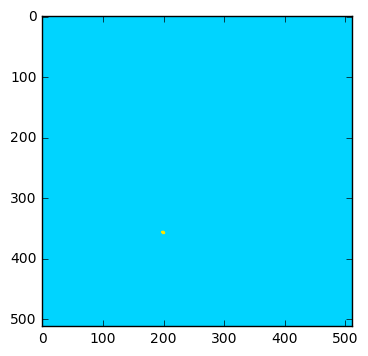

4
1
34
1


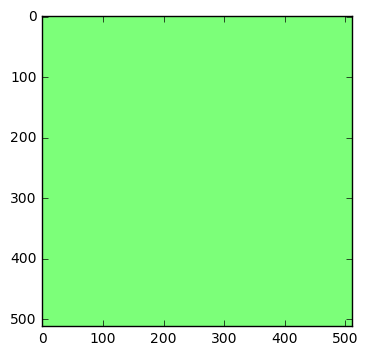

3
1
1


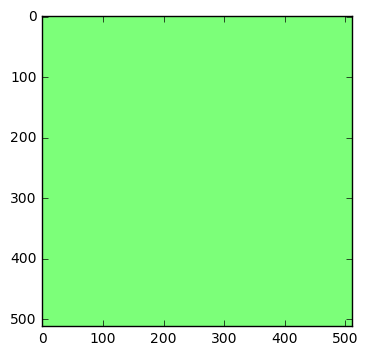

3
1
1


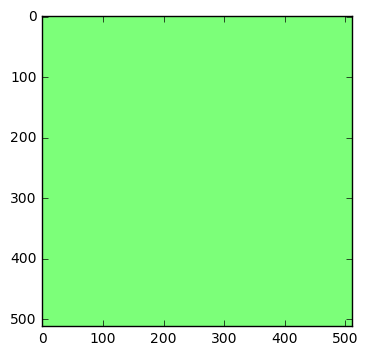

3
1
1


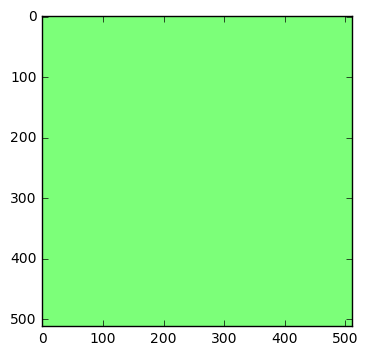

3
1
1


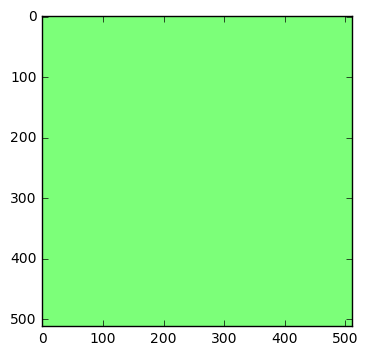

3
1
1


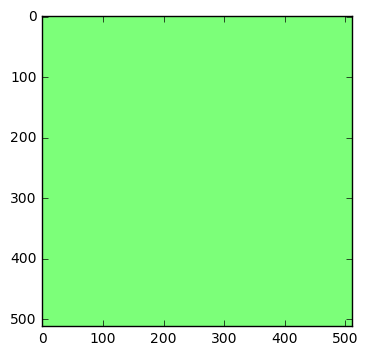

3
1
1


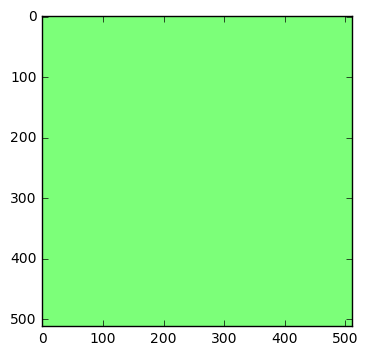

3
1
1


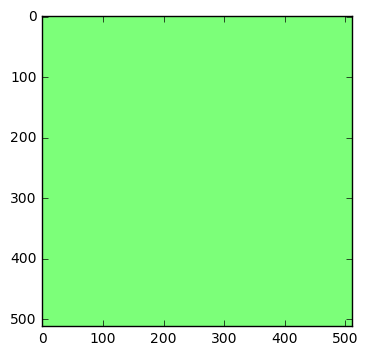

3
1
1


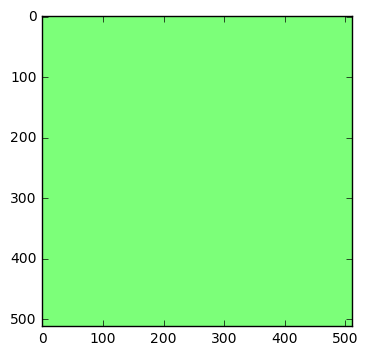

3
1
1


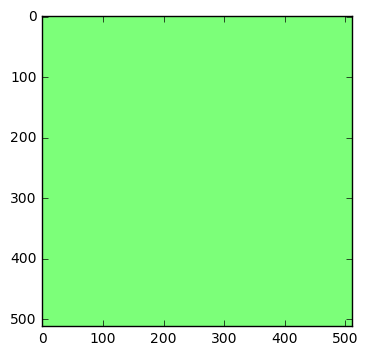

3
1
1


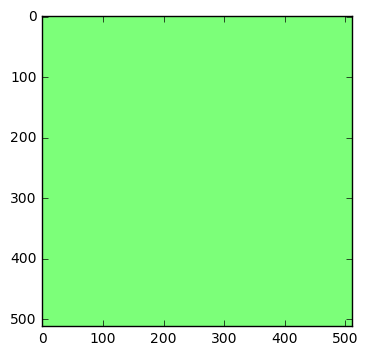

3
1
1


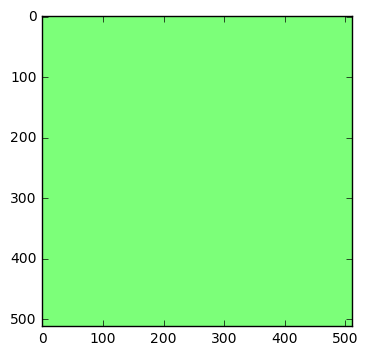

3
1
1


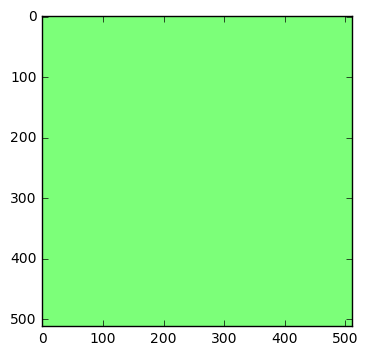

3
1
1


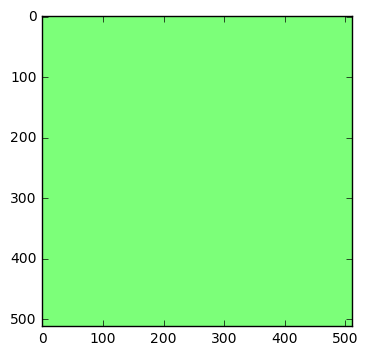

3
1
1


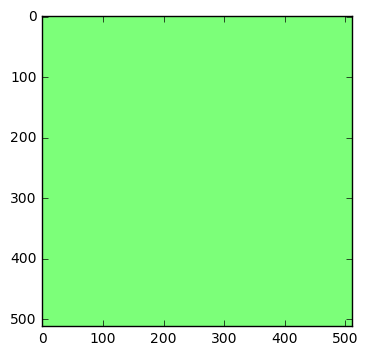

3
1
1


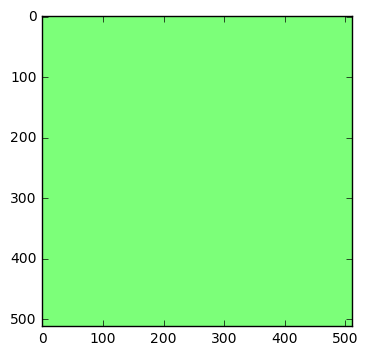

3
1
1


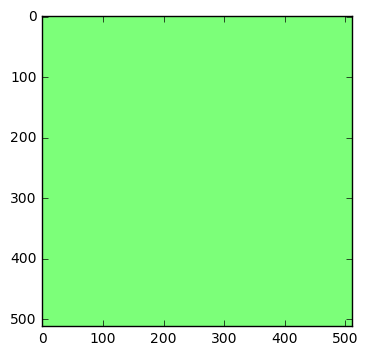

3
1
1


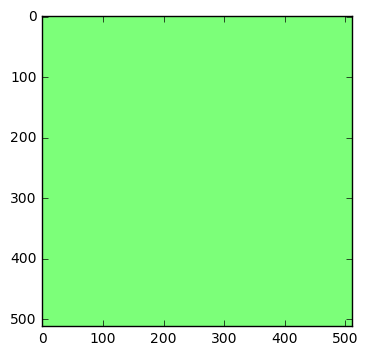

3
1
1


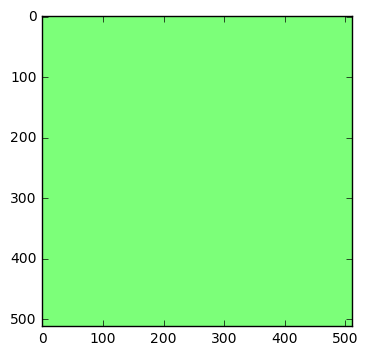

3
1
1


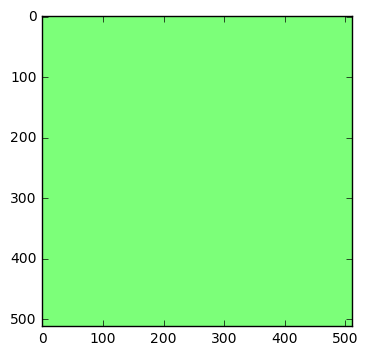

3
1
1


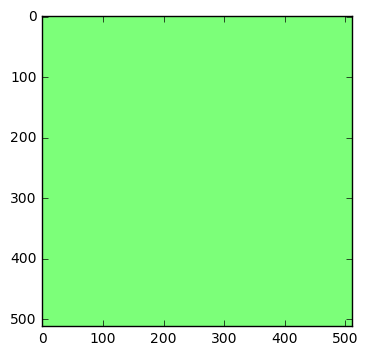

3
1
1


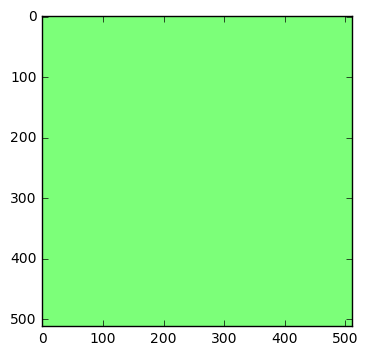

3
1
1


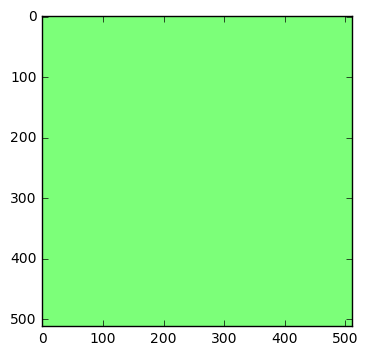

3
1
1


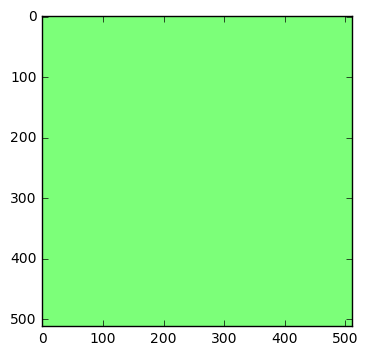

3
1
1


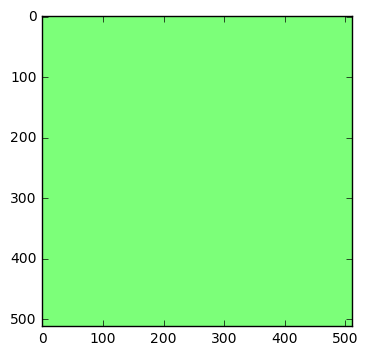

3
1
1


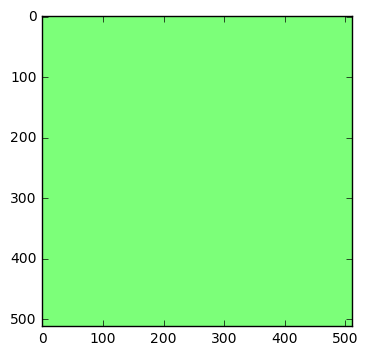

3
1
1


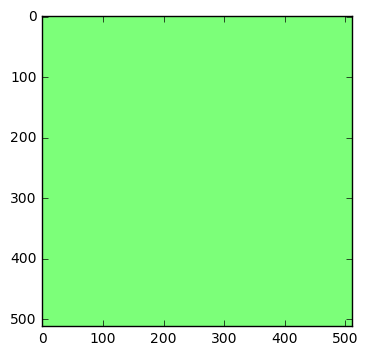

3
1
1


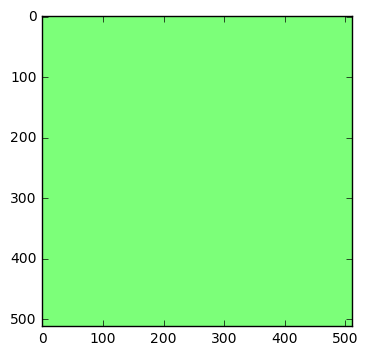

3
1
1


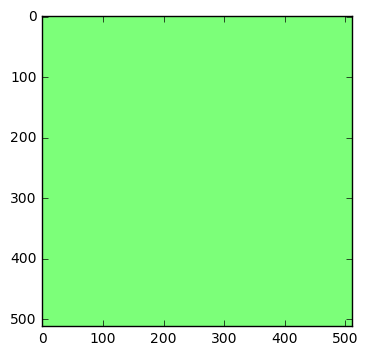

3
1
1


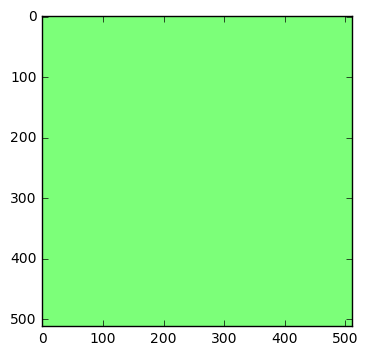

3
1
1


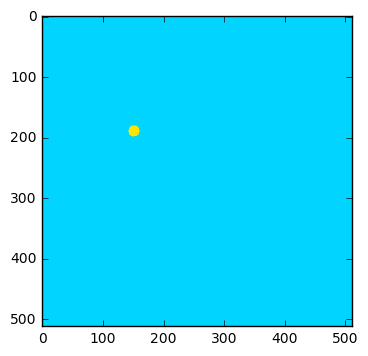

4
1
262
1


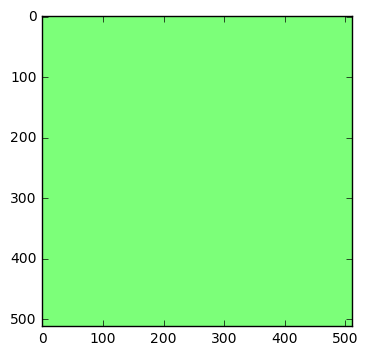

3
1
1


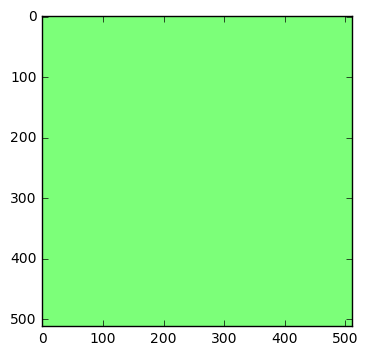

3
1
1


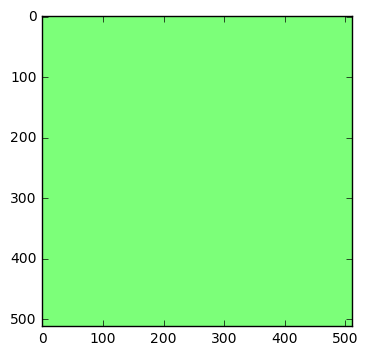

3
1
1


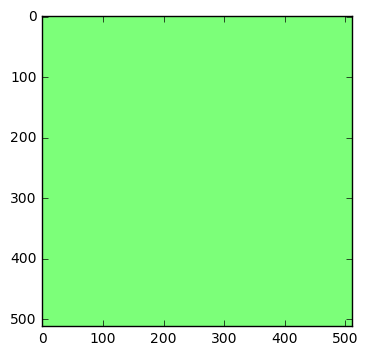

3
1
1


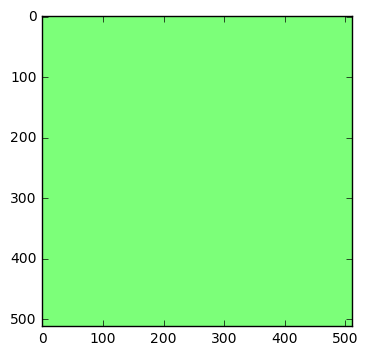

3
1
1


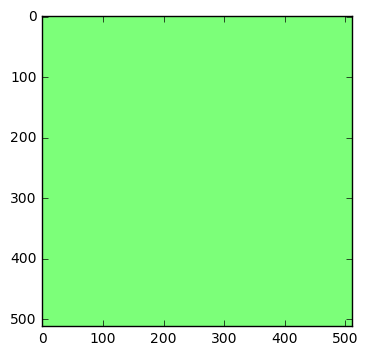

3
1
1


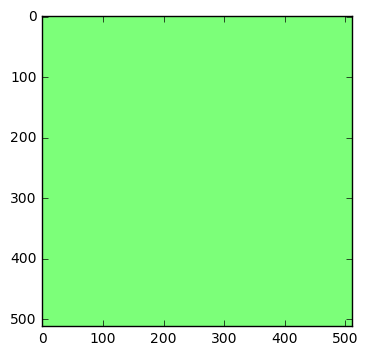

3
1
1


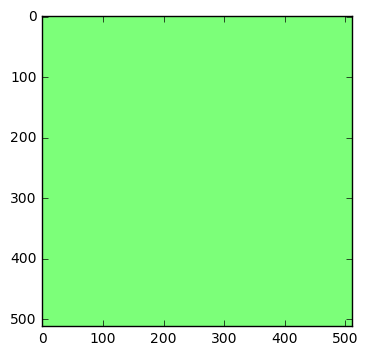

3
1
1


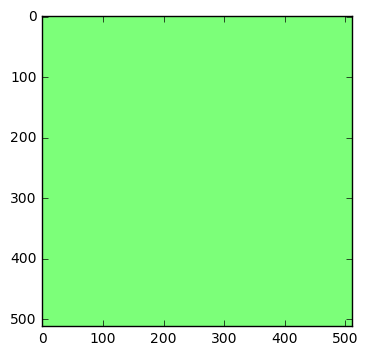

3
1
1


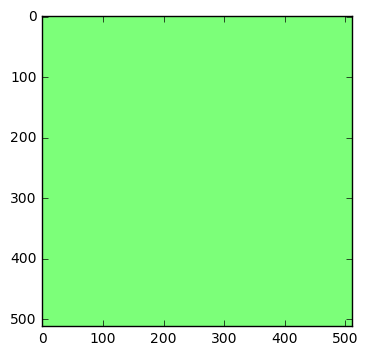

3
1
1


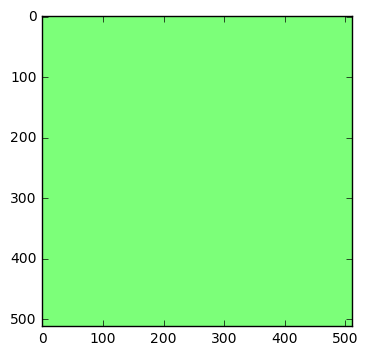

3
1
1


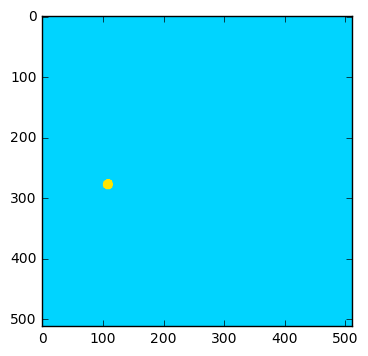

4
1
230
1


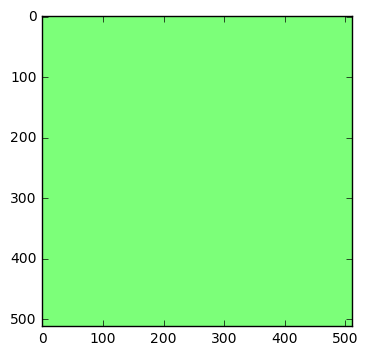

3
1
1


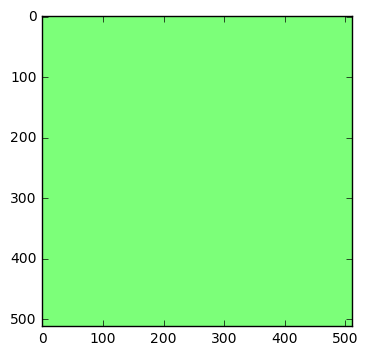

3
1
1


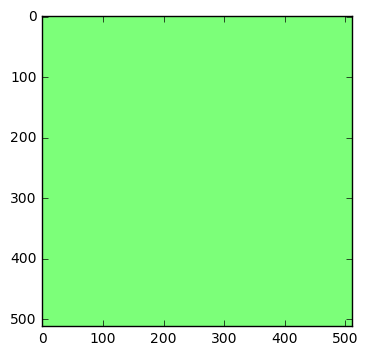

3
1
1


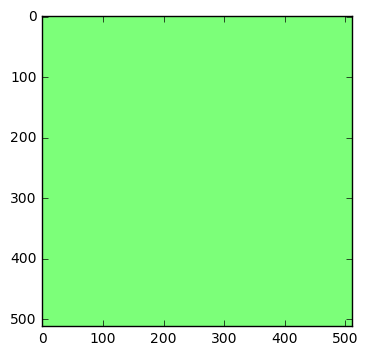

3
1
1


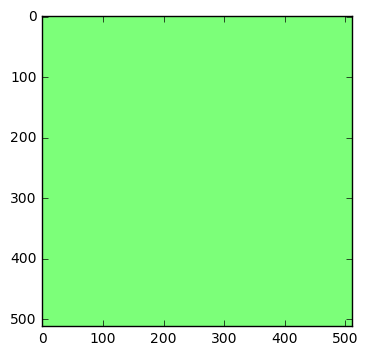

3
1
1


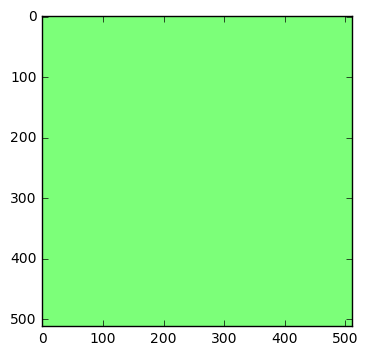

3
1
1


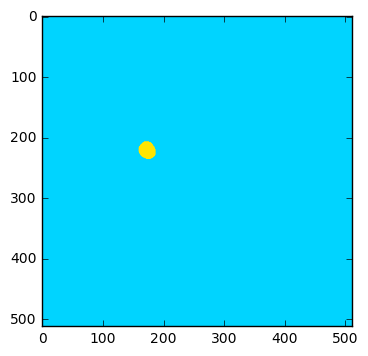

4
1
637
1


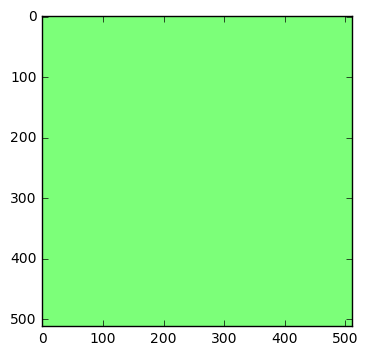

3
1
1


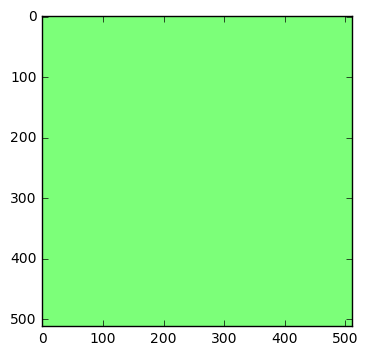

3
1
1


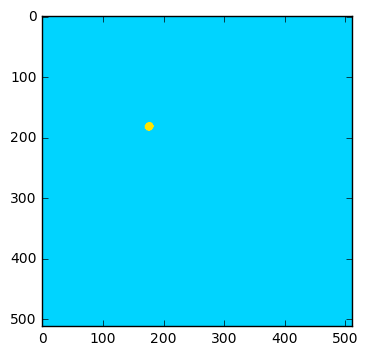

4
1
170
1


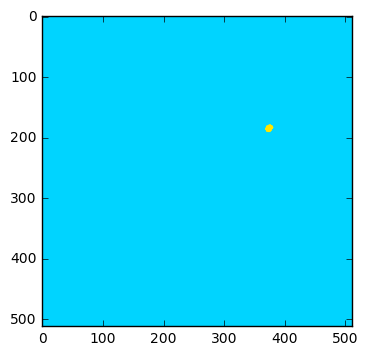

4
1
131
1


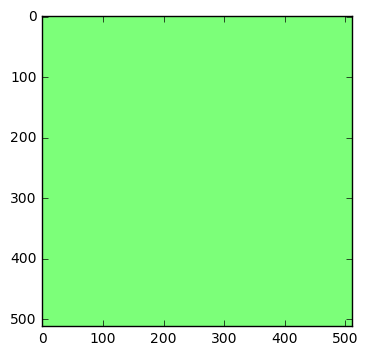

3
1
1


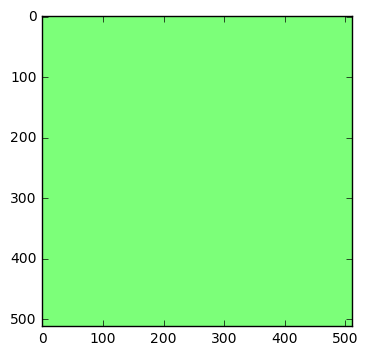

3
1
1


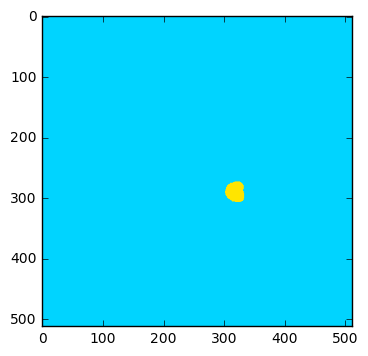

4
1
869
1


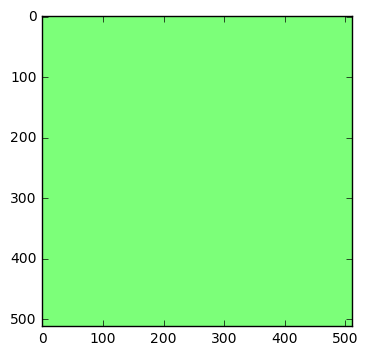

3
1
1


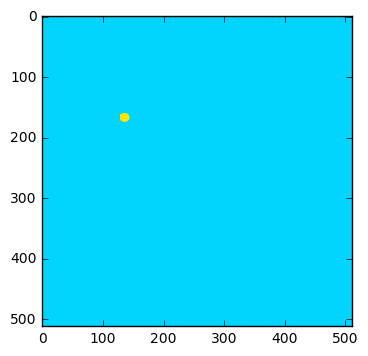

4
1
194
1


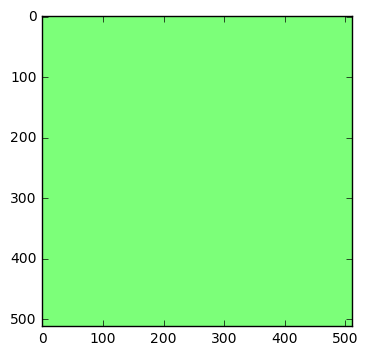

3
1
1


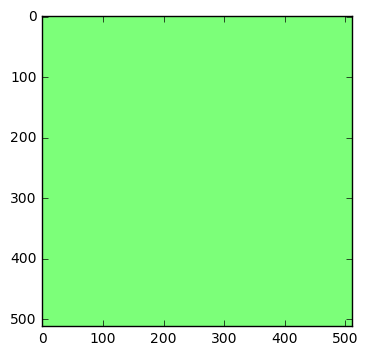

3
1
1


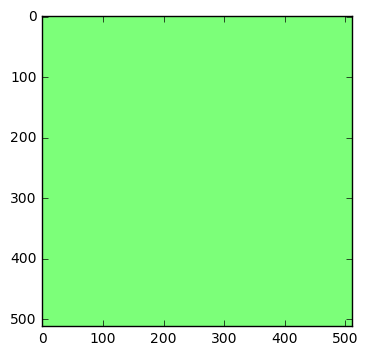

3
1
1


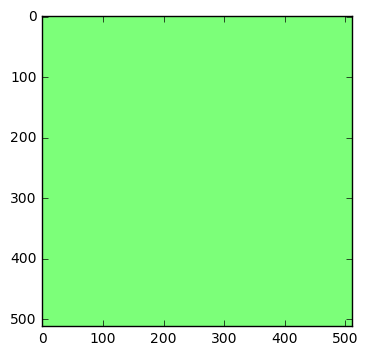

3
1
1


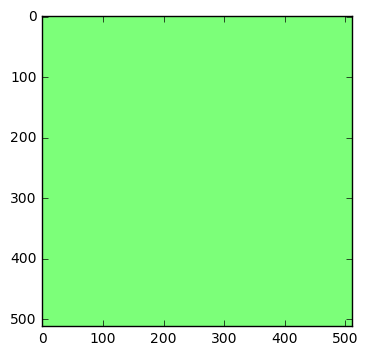

3
1
1


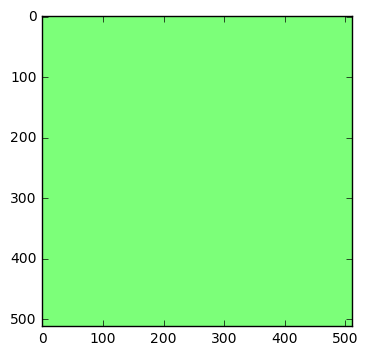

3
1
1


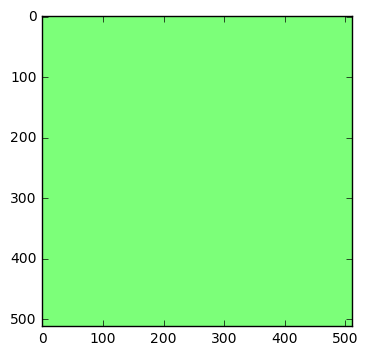

3
1
1


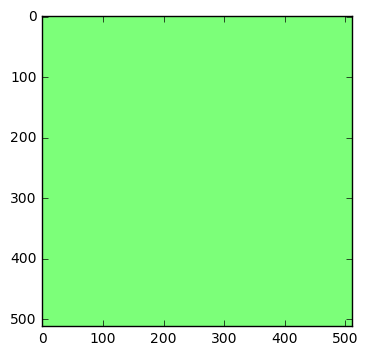

3
1
1


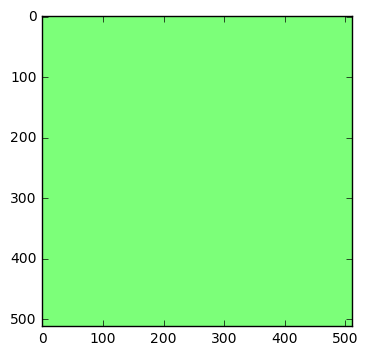

3
1
1


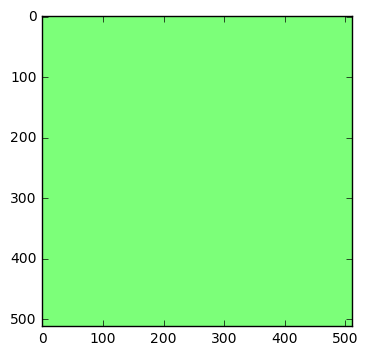

3
1
1


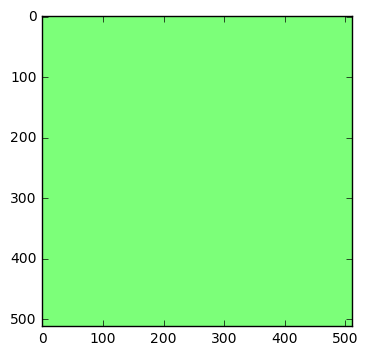

3
1
1


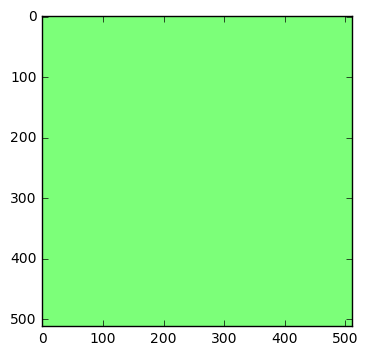

3
1
1


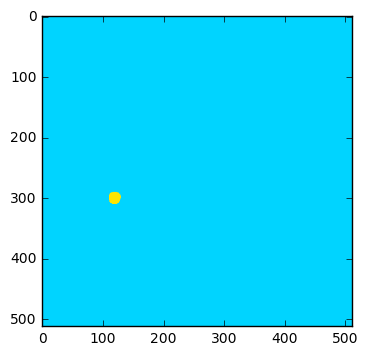

4
1
331
1


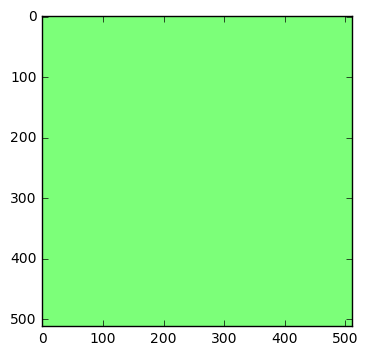

3
1
1


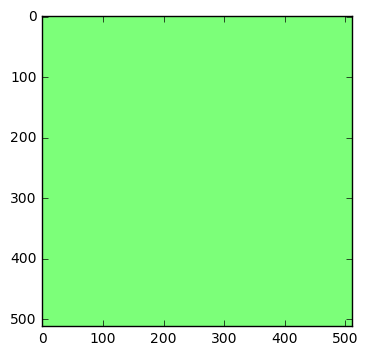

3
1
1


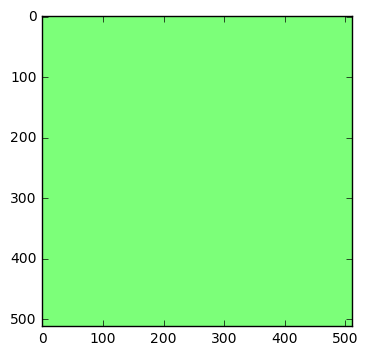

3
1
1


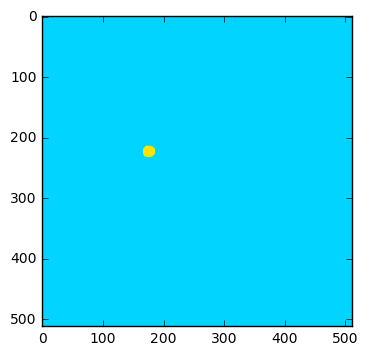

4
1
317
1


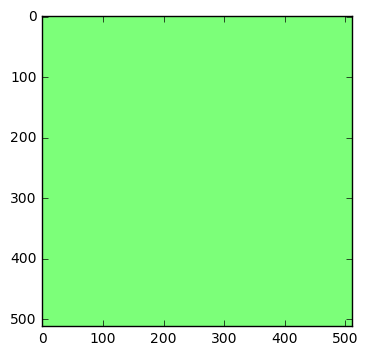

3
1
1


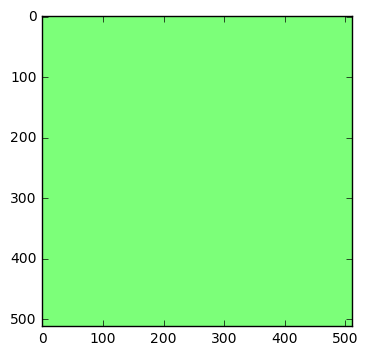

3
1
1


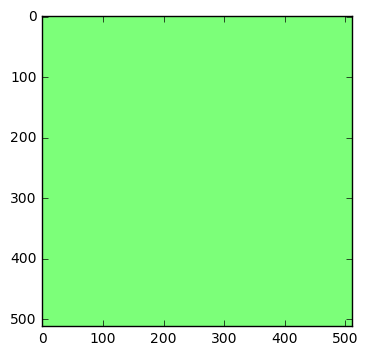

3
1
1


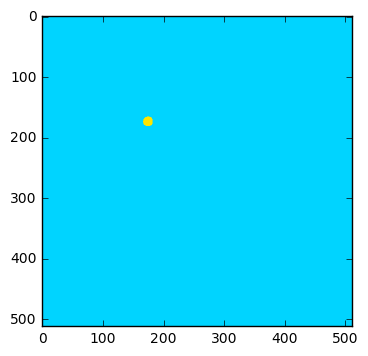

4
1
206
1


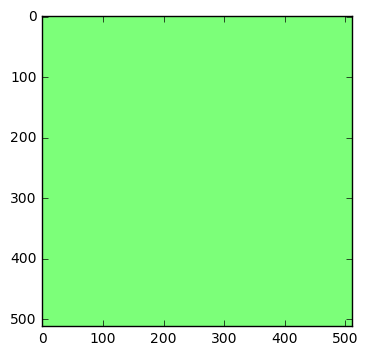

3
1
1


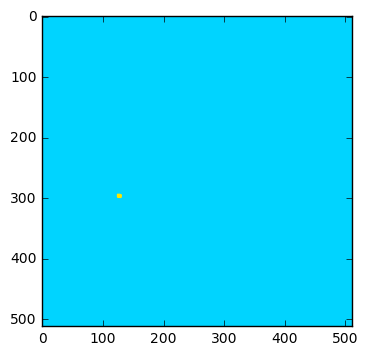

4
1
56
1


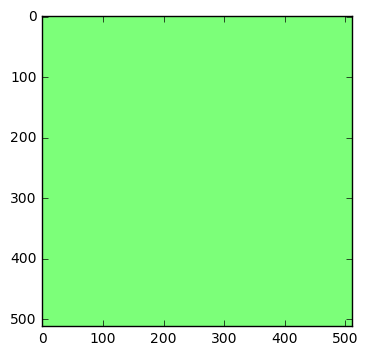

3
1
1


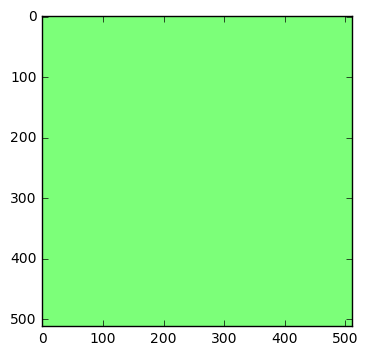

3
1
1


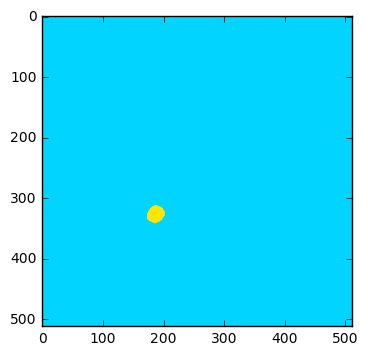

4
1
647
1


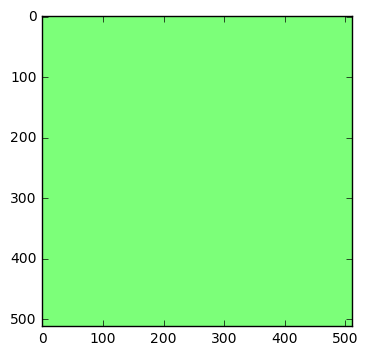

3
1
1


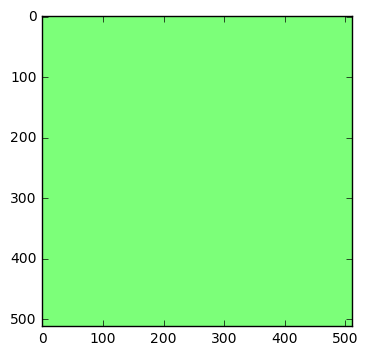

3
1
1


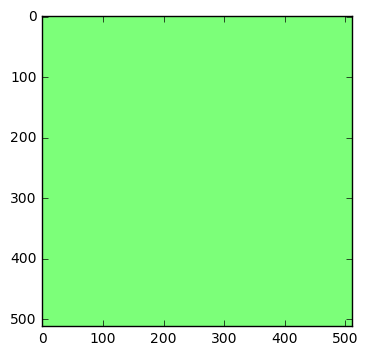

3
1
1


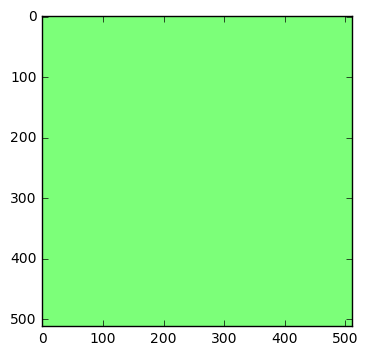

3
1
1


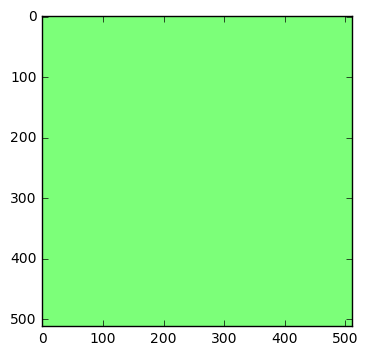

3
1
1


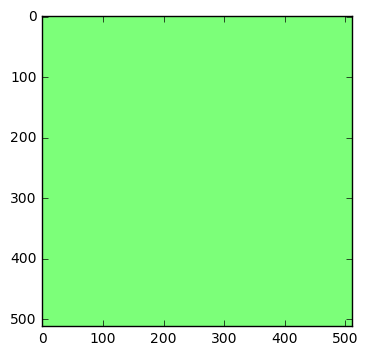

3
1
1


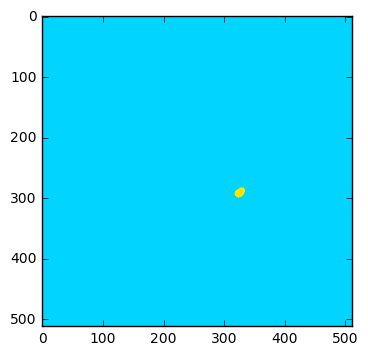

4
1
209
1


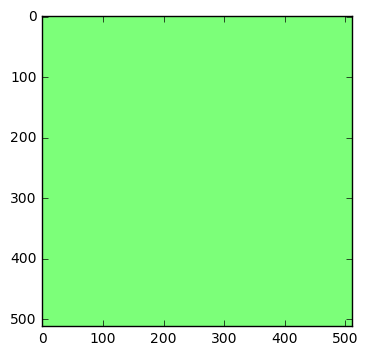

3
1
1


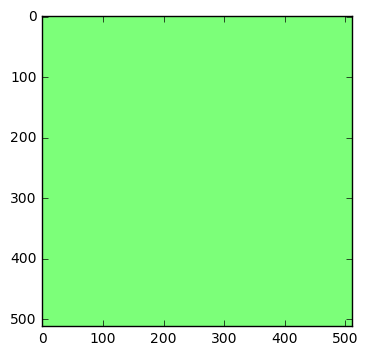

3
1
1


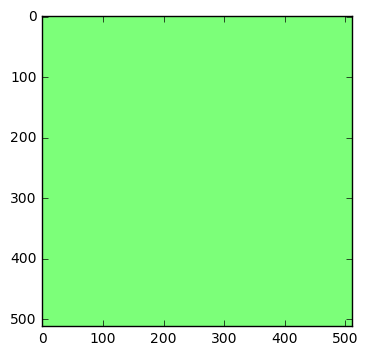

3
1
1


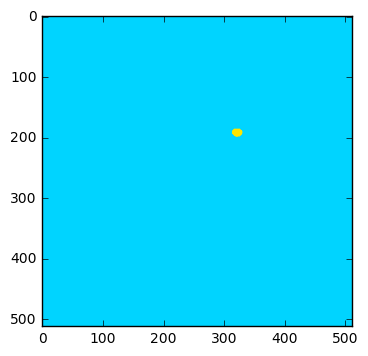

4
1
186
1


4
1
311
1


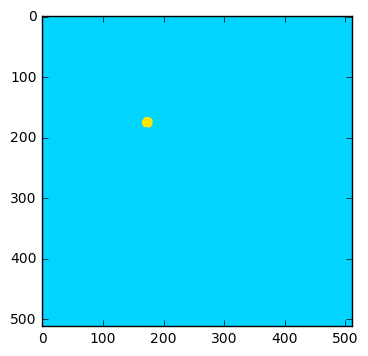

4
1
249
1


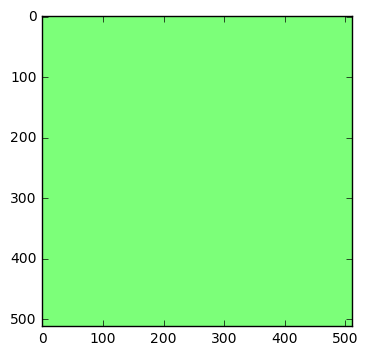

3
1
1


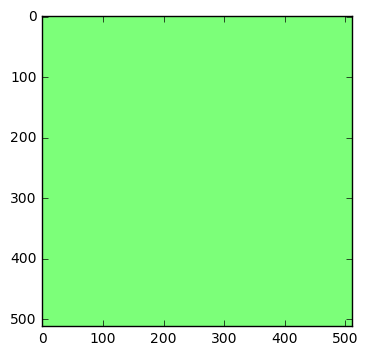

3
1
1


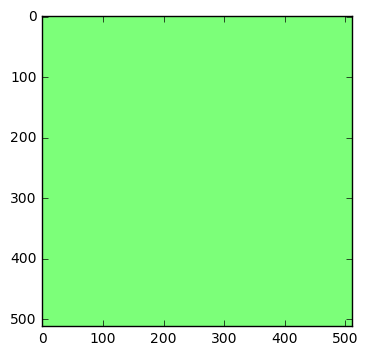

3
1
1


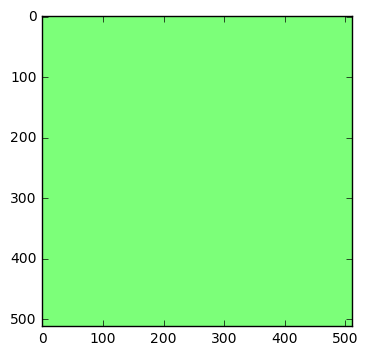

3
1
1


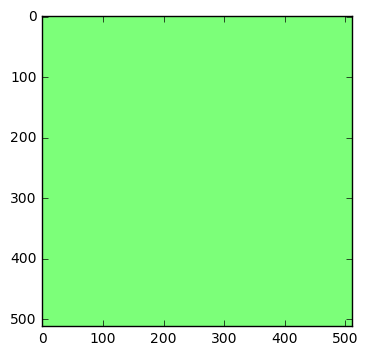

3
1
1


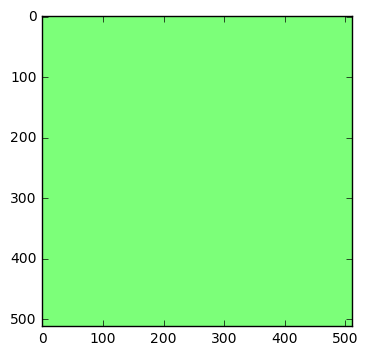

In [ ]:
createFeatureDataset()